# SECTION 1: Setup — Imports & Configuration
## Load, Inspect, and Prepare Data

WHY:
- centralize imports and paths for Phase 3
- verify input data exists and output directory ready

DATA:
- 5 epithelial-only datasets (from Phase 2, _improved suffix)
- external libraries (scanpy, numpy, pandas, WGCNA tools)

OUTPUT:
- all imports loaded, paths verified, directories created

NEXT USE:
- all libraries and paths used throughout Phase 3

In [2]:
print(f'{"PHASE 3: GENE CO-EXPRESSION NETWORK ANALYSIS (WGCNA)":^80}')

print(f'{"SECTION 1: SETUP":^80}\n')

#imported required libraries
!pip install mygene
!pip install gseapy
!pip install networkx
import pandas as pd
import numpy as np
import scanpy as sc
from pathlib import Path
import warnings
import io
import contextlib
from scipy import stats
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from collections import defaultdict
import mygene
import gseapy as gp
import seaborn as sns
from scipy.stats import spearmanr
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
from scipy.stats import mannwhitneyu
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.integrate import solve_ivp
import os
import subprocess
import gzip
import requests
import networkx as nx 
from io import StringIO
from sklearn.decomposition import PCA
import time

#suppressed benign warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

#defined directories
BASE_DIR = Path('/triumvirate/home/alexarol/breast_cancer_analysis')
DATA_DIR = BASE_DIR / 'data'
RESULTS_DIR = BASE_DIR / 'results'

#defined phase 3 output directory
PHASE3_DIR = RESULTS_DIR / 'phase3_networx_2026'
PHASE3_DIR.mkdir(exist_ok=True)

#defined input files (from Phase 2)
epithelial_files = {
    'Normal': RESULTS_DIR / 'adata_normal_epithelial_improved.h5ad',
    'ER_Positive': RESULTS_DIR / 'adata_er_positive_epithelial_improved.h5ad',
    'HER2_Positive': RESULTS_DIR / 'adata_her2_positive_epithelial_improved.h5ad',
    'TripleNegative': RESULTS_DIR / 'adata_triplenegative_epithelial_improved.h5ad',
    'TripleNegative_BRCA1': RESULTS_DIR / 'adata_triplenegative_brca1_epithelial_improved.h5ad',
    'Preneoplastic': RESULTS_DIR / 'adata_brca1_preneoplastic_epithelial_improved.h5ad'
}

#verified input files exist
print(f'verifying Phase 2 output files\n')
for group_name, file_path in epithelial_files.items():
    status = 'OK' if file_path.exists() else 'NOT OK'
    print(f'{status} {group_name:25} {file_path.name}')

print(f'\n output directory: {PHASE3_DIR}\n')

"""#defined WGCNA parameters (explained in notebook markdown)
WGCNA_PARAMS = {
    'soft_power_range': range(1, 31),          #test β from 1 to 30
    'min_module_size': 30,                     #minimum genes per module
    'deep_split': 2,                           #moderate aggressiveness
    'correlation_method': 'pearson',           #linear relationship
    'max_block_size': 20000,                   #memory efficiency
    'r_squared_threshold': 0.85,               #scale-free fit criterion
}
print(f'WGCNA parameters configured:')
for param, value in WGCNA_PARAMS.items():
    if param != 'soft_power_range':
        print(f'  {param:25} {value}')
print(f'\nOK setup complete\n')"""

              PHASE 3: GENE CO-EXPRESSION NETWORK ANALYSIS (WGCNA)              
                                SECTION 1: SETUP                                

verifying Phase 2 output files

OK Normal                    adata_normal_epithelial_improved.h5ad
OK ER_Positive               adata_er_positive_epithelial_improved.h5ad
OK HER2_Positive             adata_her2_positive_epithelial_improved.h5ad
OK TripleNegative            adata_triplenegative_epithelial_improved.h5ad
OK TripleNegative_BRCA1      adata_triplenegative_brca1_epithelial_improved.h5ad
OK Preneoplastic             adata_brca1_preneoplastic_epithelial_improved.h5ad

 output directory: /triumvirate/home/alexarol/breast_cancer_analysis/results/phase3_networx_2026



"#defined WGCNA parameters (explained in notebook markdown)\nWGCNA_PARAMS = {\n    'soft_power_range': range(1, 31),          #test β from 1 to 30\n    'min_module_size': 30,                     #minimum genes per module\n    'deep_split': 2,                           #moderate aggressiveness\n    'correlation_method': 'pearson',           #linear relationship\n    'max_block_size': 20000,                   #memory efficiency\n    'r_squared_threshold': 0.85,               #scale-free fit criterion\n}\nprint(f'WGCNA parameters configured:')\nfor param, value in WGCNA_PARAMS.items():\n    if param != 'soft_power_range':\n        print(f'  {param:25} {value}')\nprint(f'\nOK setup complete\n')"

I have found a guthub repo: https://github.com/evanpeikon/SmallSeqFlow?tab=readme-ov-file#load-inspect-and-prepare-data
i will use it as an idea source for some parts of the sript in this notebook

## Converting Ensemble IDs to Gene Names 
this is one of the steps in the repo, but i have already done this step earlier

so now, i am jsut checking if it si alright

In [5]:
print(f'\n{" VERIFY GENE NAMES":^80}\n')

# Load one sample to check gene naming
sample_file = RESULTS_DIR / 'adata_normal_epithelial_improved.h5ad'
print(f"Loading sample file to verify gene names")
adata_check = sc.read_h5ad(sample_file)
adata_check.obs_names_make_unique()

print(f"\n✓ File loaded: {sample_file.name}")
print(f"  Cells: {adata_check.n_obs:,}")
print(f"  Genes: {adata_check.n_vars:,}\n")

# Check first 30 gene names
print(f"First 30 gene names (.var_names):")
for i, gene in enumerate(adata_check.var_names[:30], 1):
    print(f"  {i:2d}. {gene}")

print(f"\nLast 10 gene names:")
for i, gene in enumerate(adata_check.var_names[-10:], adata_check.n_vars - 9):
    print(f"  {i:>5d}. {gene}")

# Check if genes look like Ensembl IDs or gene symbols
gene_sample = adata_check.var_names[:50]
ensembl_like = sum(1 for g in gene_sample if g.startswith('ENSG'))
symbol_like = sum(1 for g in gene_sample if g.isupper() and len(g) < 20)

print(f"\n{'='*80}")
print(f"GENE NAME ANALYSIS")
print(f"{'='*80}\n")

print(f"Sample of first 50 genes:")
print(f"  Ensembl IDs (ENSG format): {ensembl_like}/50")
print(f"  Gene symbols (UPPERCASE):  {symbol_like}/50\n")

if ensembl_like > 25:
    print(f" Your genes appear to be ENSEMBL IDs")
elif symbol_like > 25:
    print(f" Your genes are ALREADY GENE SYMBOLS")
else:
    print(f" Gene names are mixed or unclear")

print(f"\n{'='*80}\n")

# Show gene name format
print(f"Gene name format examples:")
for i, gene in enumerate(adata_check.var_names[::5000][:5], 1):
    print(f"  {i}. {gene} (length: {len(gene)})")

print(f"\nConclusion:")
print(f" Your .h5ad files have: GENE SYMBOLS (human-readable names)")



                                VERIFY GENE NAMES                               

Loading sample file to verify gene names

✓ File loaded: adata_normal_epithelial_improved.h5ad
  Cells: 83,522
  Genes: 33,514

First 30 gene names (.var_names):
   1. MIR1302-2HG
   2. FAM138A
   3. OR4F5
   4. AL627309.1
   5. AL627309.3
   6. AL627309.2
   7. AL627309.4
   8. AL732372.1
   9. OR4F29
  10. AC114498.1
  11. OR4F16
  12. AL669831.2
  13. AL669831.5
  14. FAM87B
  15. LINC00115
  16. FAM41C
  17. AL645608.7
  18. AL645608.3
  19. AL645608.5
  20. AL645608.1
  21. SAMD11
  22. NOC2L
  23. KLHL17
  24. PLEKHN1
  25. PERM1
  26. AL645608.8
  27. HES4
  28. ISG15
  29. AL645608.2
  30. AGRN

Last 10 gene names:
  33505. AC007325.2
  33506. BX072566.1
  33507. AL354822.1
  33508. AC023491.2
  33509. AC004556.1
  33510. AC233755.2
  33511. AC233755.1
  33512. AC240274.1
  33513. AC213203.1
  33514. FAM231C

GENE NAME ANALYSIS

Sample of first 50 genes:
  Ensembl IDs (ENSG format): 0/50
  Gene s

## Exploratory Data Analysis
This is the next step they have in SmallSeqFlow repo, i am jsut tailoring their code to my analysis. 

This function creates a comprehensive quality control visualization suite for RNA-seq data that helps researchers identify potential issues or batch effects before proceeding with downstream analysis. 

It takes a count matrix (with genes as rows and samples as columns) and produces several key visualizations and metrics that serve different analytical purpose. 



Now i will: 

check if the Normal sample is in proper QC condition before proceeding. The EDA will tell us:

Are cells good quality?

Are there batch effects or outliers?

Can we proceed to downstream analysis?

Should we be concerned about the matrix size?
Short answer: NO. This is actually very normal and expected for scRNA-seq. Let me break it down:

Metric	Your Data	Assessment
83,522 cells	Large, but typical	Modern 10x Genomics = 10k-100k cells/sample ✅
33,514 genes	Standard	Human genome ≈ 20k genes, includes some ncRNAs ✅
94% sparsity	Expected!	scRNA-seq is very sparse (most cells don't express most genes) ✅
Matrix size	2.8 billion values	Large but manageable in memory (~22 GB sparse) ✓

| SmallSeqFlow (Bulk)                       | My Version (scRNA-seq)                     | Why                                         |
| ----------------------------------------- | -------------------------------------------- | ------------------------------------------- |
| Input: pandas DataFrame (genes × samples) | Input: AnnData object                        | Native Scanpy format                        |
| "Total reads per sample"                  | "Total UMIs per cell" (histogram)            | Cells are my "samples"                      |
| "Sample correlation heatmap"              | "Gene correlation heatmap" (100 cell sample) | 83k cells unreadable; genes more meaningful |
| All genes visualized                      | 50 random genes sampled                      | 33k genes too crowded                       |
| All samples in dendrogram                 | 500 cell sample                              | 83k cells creates 10-meter figure!          |
| Cell-level metrics                        | Cell-level + sparsity                        | scRNA-seq specific                          |


                        SECTION 3: EDA - TRIPLE NEGATIVE                        

QUICK TEST: 500 cells

Loading data...
Test subset: 500 cells

[EDA] Processing 500 cells × 33,514 genes...
[EDA] Computing correlations...
[EDA] Computing PCA...
[EDA] Creating dendrogram...
[EDA] Calculating metrics...

QC METRICS - TN Test (500 cells)
Cells:                     500
Genes:                  33,514
Total UMIs:          3,679,641
Mean UMIs/cell:         7359.3
Median UMIs/cell:       5259.5
CV UMIs:                 1.063
PC1 variance:            58.7%
PC2 variance:             2.4%

✓ Time: 9.4s



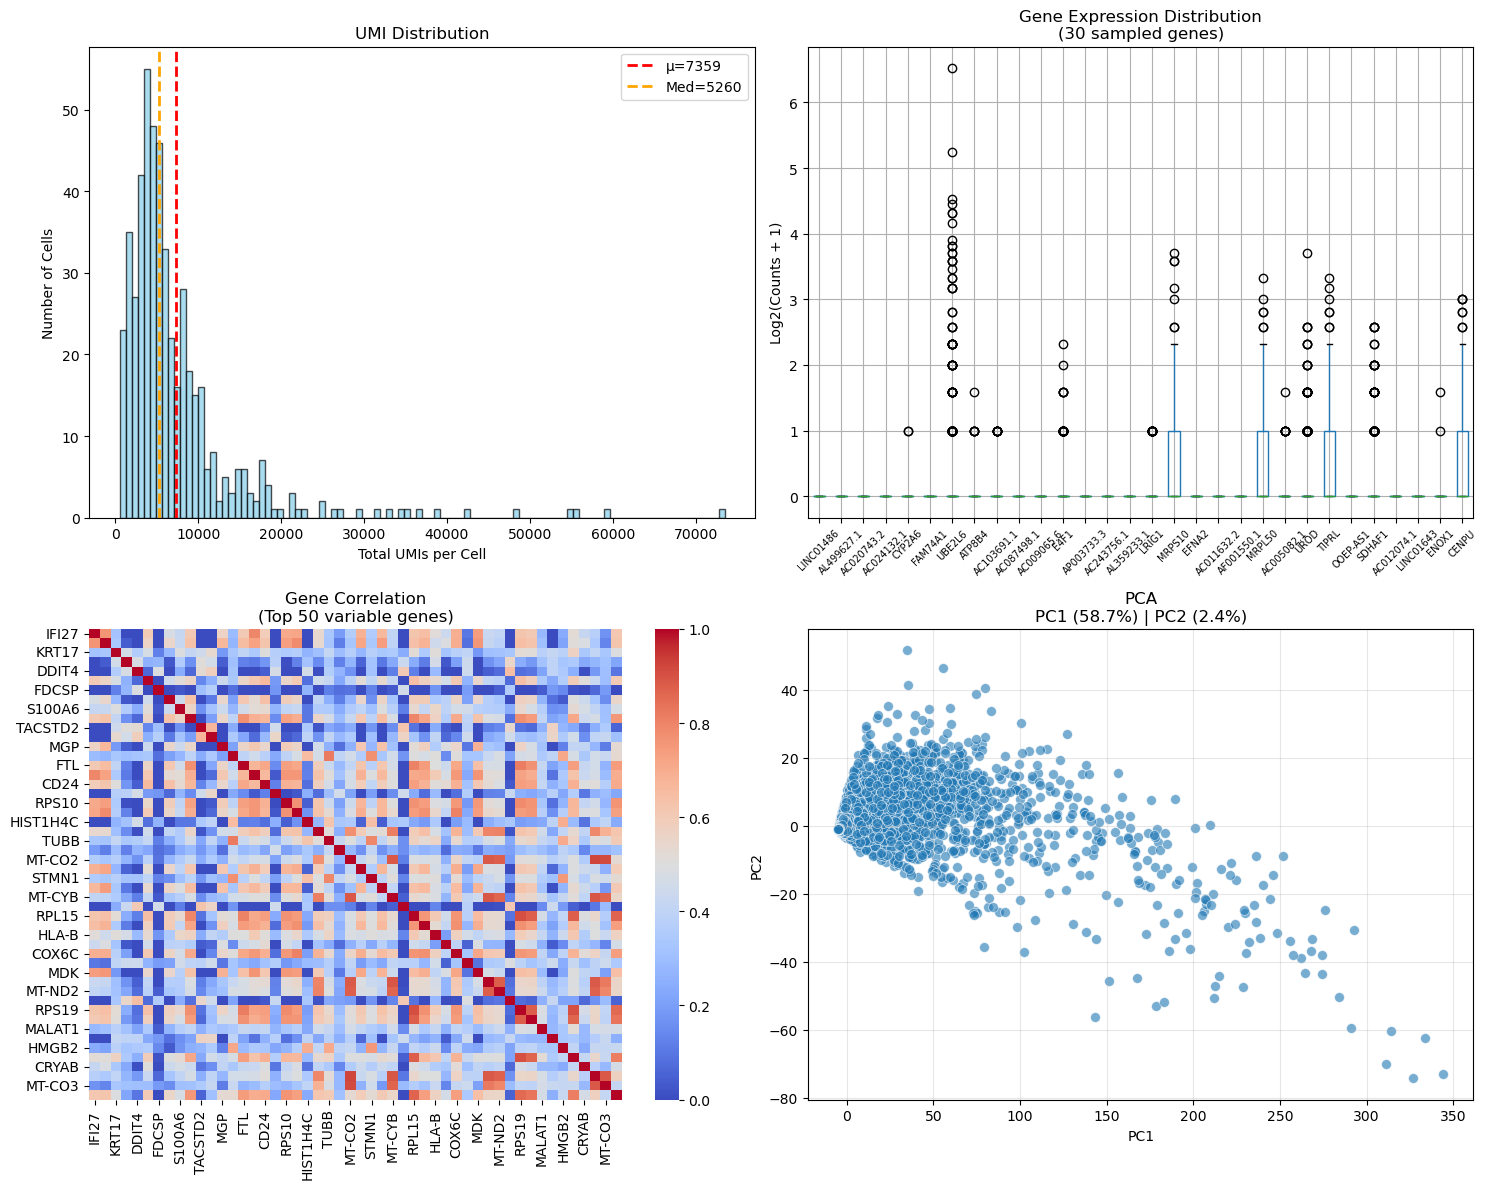

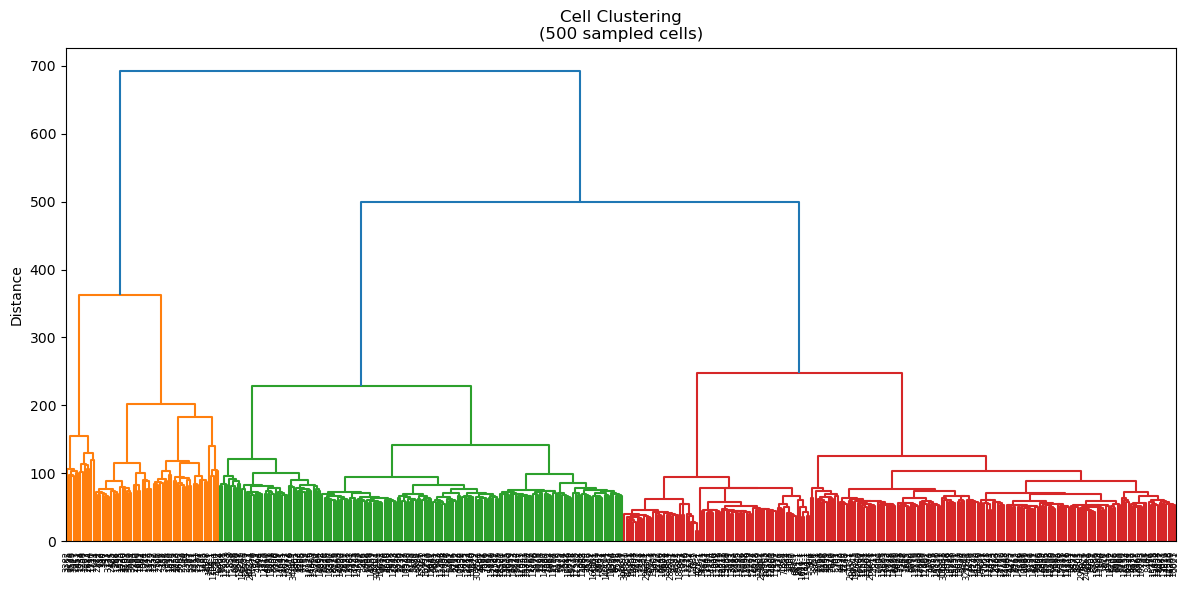


FULL ANALYSIS: All cells

[EDA] Processing 7,561 cells × 33,514 genes...
[EDA] Computing correlations...
[EDA] Computing PCA...
[EDA] Creating dendrogram...
[EDA] Calculating metrics...

QC METRICS - TN Full (7,561 cells)
Cells:                   7,561
Genes:                  33,514
Total UMIs:         57,242,015
Mean UMIs/cell:         7570.7
Median UMIs/cell:       5326.0
CV UMIs:                 1.131
PC1 variance:            58.7%
PC2 variance:             2.2%

✓ Time: 33.3s



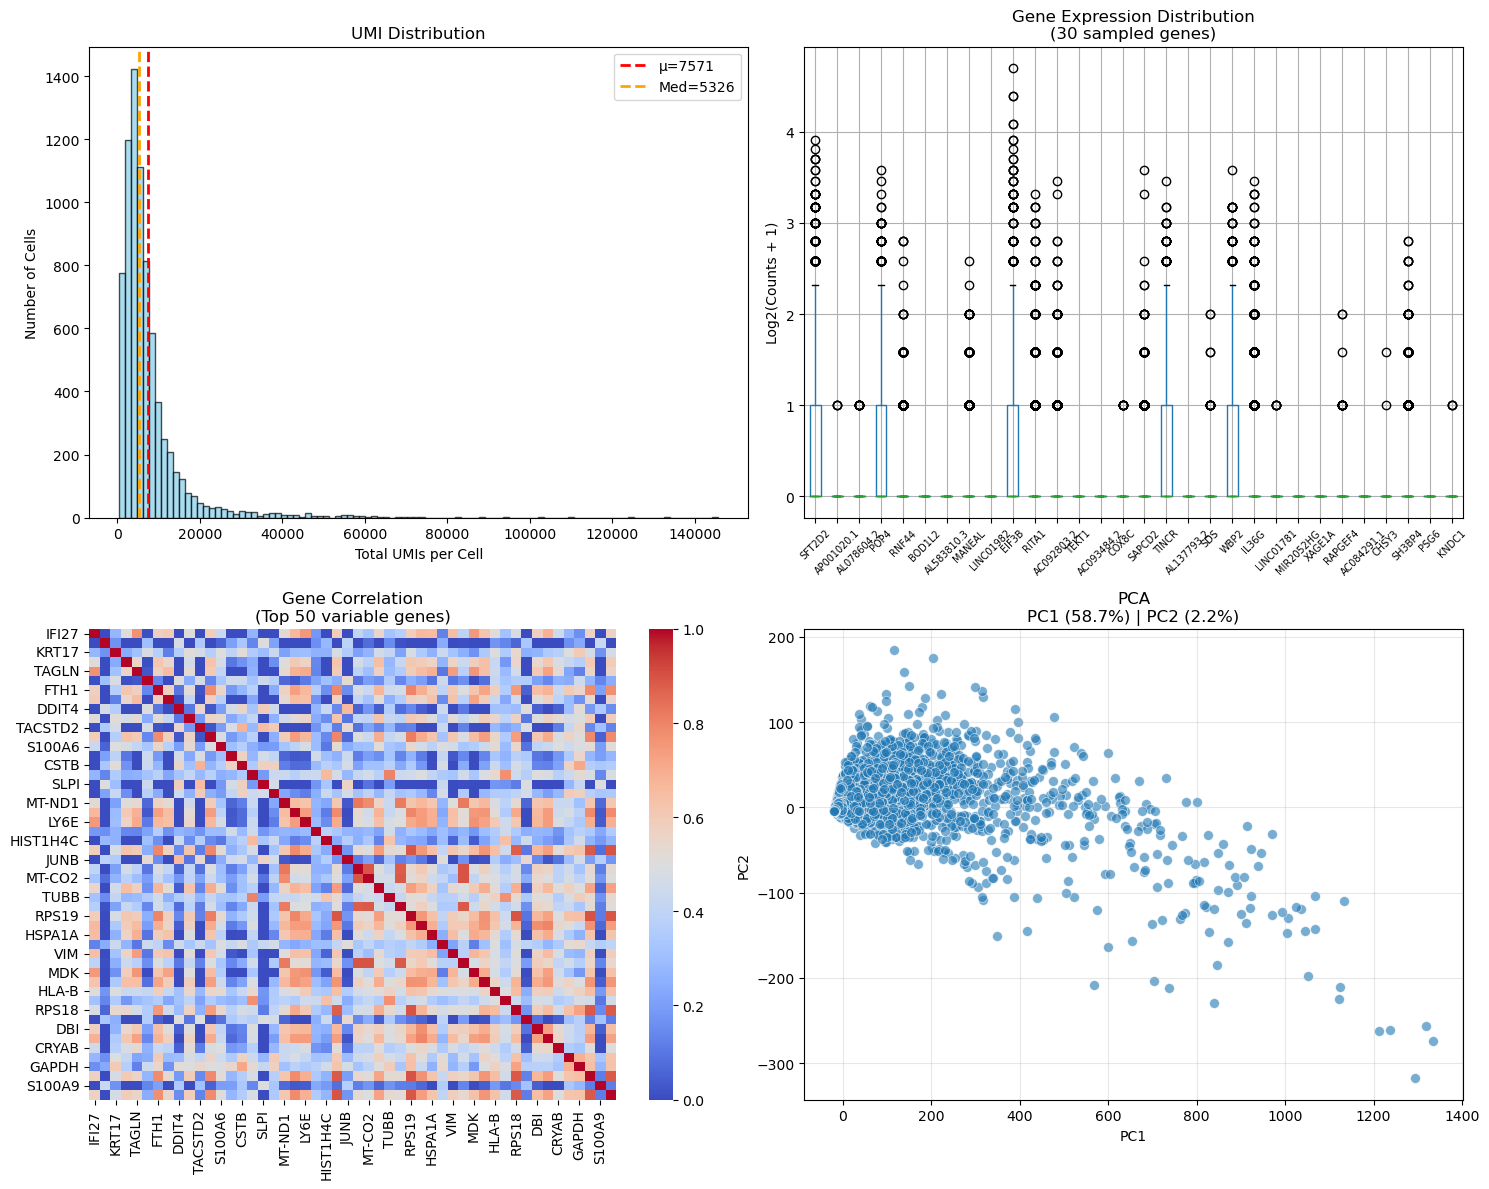

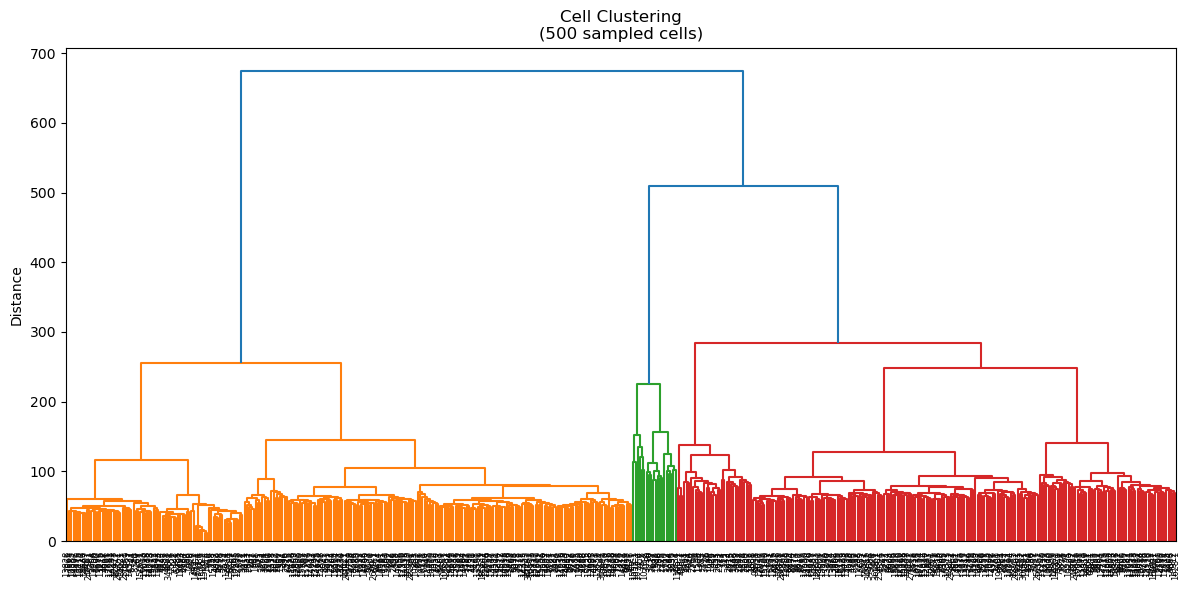


COMPARISON
Metric               Test                 Full                
------------------------------------------------------------
Cells                500                  7,561               
Mean UMIs            7359.3               7570.7              
CV UMIs              1.063                1.131               
PC1 var              58.7%                58.7%               

✓ EDA complete. Data quality looks good.
✓ Next: Run same EDA on Normal epithelial (83k cells)
✓ Then: Install RECODE and select HVGs




In [10]:
"""
SECTION 3: EXPLORATORY DATA ANALYSIS (EDA)
==========================================

Minimalist version - optimized for speed and memory
Treats cells as "samples" for compatibility with SmallSeqFlow
"""

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram

print(f'\n{"SECTION 3: EDA - TRIPLE NEGATIVE":^80}\n')

def eda_scrnaseq(adata, name, n_genes=30, figure_size=(15, 12)):
    """
    Minimal EDA function - optimized for large scRNA-seq datasets
    
    Parameters:
    adata: AnnData object
    name: str - dataset name
    n_genes: int - genes to sample in boxplot
    figure_size: tuple - figure dimensions
    
    Returns:
    fig1, fig2, stats dict
    """
    
    print(f"[EDA] Processing {adata.n_obs:,} cells × {adata.n_vars:,} genes...")
    
    # Convert to sparse-safe format
    X = adata.X.toarray() if hasattr(adata.X, 'toarray') else adata.X
    df = pd.DataFrame(X, index=adata.obs_names, columns=adata.var_names)
    
    # Core calculations
    total_counts = df.sum(axis=1)
    log_df = df.apply(lambda x: np.log2(x + 1))
    
    # Figure 1: 4-panel visualization
    fig1, axes = plt.subplots(2, 2, figsize=figure_size)
    
    # Panel 1: UMI histogram
    axes[0, 0].hist(total_counts, bins=100, color='skyblue', alpha=0.7, edgecolor='black')
    axes[0, 0].axvline(total_counts.mean(), color='red', linestyle='--', linewidth=2, 
                       label=f'μ={total_counts.mean():.0f}')
    axes[0, 0].axvline(total_counts.median(), color='orange', linestyle='--', linewidth=2,
                       label=f'Med={total_counts.median():.0f}')
    axes[0, 0].set_ylabel('Number of Cells')
    axes[0, 0].set_xlabel('Total UMIs per Cell')
    axes[0, 0].set_title('UMI Distribution')
    axes[0, 0].legend()
    
    # Panel 2: Gene expression boxplot (sampled genes)
    sample_genes = np.random.choice(df.columns, min(n_genes, len(df.columns)), replace=False)
    log_df[sample_genes].boxplot(ax=axes[0, 1])
    axes[0, 1].set_ylabel('Log2(Counts + 1)')
    axes[0, 1].set_title(f'Gene Expression Distribution\n({n_genes} sampled genes)')
    axes[0, 1].tick_params(axis='x', rotation=45, labelsize=7)
    
    # Panel 3: Gene correlation (top 50 variable genes only)
    print(f"[EDA] Computing correlations...")
    top_vars = log_df.var().nlargest(50).index
    corr = log_df[top_vars].corr()
    sns.heatmap(corr, cmap='coolwarm', center=0.5, vmin=0, vmax=1, ax=axes[1, 0])
    axes[1, 0].set_title('Gene Correlation\n(Top 50 variable genes)')
    
    # Panel 4: PCA
    print(f"[EDA] Computing PCA...")
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(StandardScaler().fit_transform(log_df.T))
    pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'], index=df.columns)
    sns.scatterplot(data=pca_df, x='PC1', y='PC2', s=50, alpha=0.6, ax=axes[1, 1])
    axes[1, 1].set_title(f'PCA\nPC1 ({pca.explained_variance_ratio_[0]:.1%}) | PC2 ({pca.explained_variance_ratio_[1]:.1%})')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Figure 2: Dendrogram (max 500 cells for speed)
    print(f"[EDA] Creating dendrogram...")
    fig2 = plt.figure(figsize=(12, 6))
    n_dendro = min(500, adata.n_obs)
    idx = np.random.choice(len(df), n_dendro, replace=False)
    h = linkage(log_df.iloc[idx].values, 'ward')
    dendrogram(h, labels=df.index[idx], leaf_font_size=6)
    plt.xticks(rotation=90, fontsize=6)
    plt.ylabel('Distance')
    plt.title(f'Cell Clustering\n({n_dendro} sampled cells)')
    plt.tight_layout()
    
    # QC statistics
    print(f"[EDA] Calculating metrics...")
    stats = {
        'n_cells': adata.n_obs,
        'n_genes': adata.n_vars,
        'total_umis': int(total_counts.sum()),
        'mean_umis': float(total_counts.mean()),
        'median_umis': float(total_counts.median()),
        'cv_umis': float(total_counts.std() / total_counts.mean()),
        'pc1_var': float(pca.explained_variance_ratio_[0]),
        'pc2_var': float(pca.explained_variance_ratio_[1])
    }
    
    print(f"\n{'='*80}")
    print(f"QC METRICS - {name}")
    print(f"{'='*80}")
    print(f"Cells:              {stats['n_cells']:>10,}")
    print(f"Genes:              {stats['n_genes']:>10,}")
    print(f"Total UMIs:         {stats['total_umis']:>10,.0f}")
    print(f"Mean UMIs/cell:     {stats['mean_umis']:>10.1f}")
    print(f"Median UMIs/cell:   {stats['median_umis']:>10.1f}")
    print(f"CV UMIs:            {stats['cv_umis']:>10.3f}")
    print(f"PC1 variance:       {stats['pc1_var']:>10.1%}")
    print(f"PC2 variance:       {stats['pc2_var']:>10.1%}")
    print(f"{'='*80}\n")
    
    return fig1, fig2, stats

# ============================================================================
# RUN EDA ON TRIPLE NEGATIVE
# ============================================================================

print("="*80)
print("QUICK TEST: 500 cells")
print("="*80 + "\n")

print("Loading data...")
tn_path = Path('/triumvirate/home/alexarol/breast_cancer_analysis/results/adata_triplenegative_epithelial_improved.h5ad')
adata_tn = sc.read_h5ad(tn_path)
adata_tn.obs_names_make_unique()

# Test on 500 cells
np.random.seed(42)
idx = np.random.choice(adata_tn.n_obs, min(500, adata_tn.n_obs), replace=False)
adata_test = adata_tn[idx].copy()

print(f"Test subset: {adata_test.n_obs} cells\n")

t0 = time.time()
fig1_test, fig2_test, stats_test = eda_scrnaseq(adata_test, "TN Test (500 cells)")
print(f"✓ Time: {time.time()-t0:.1f}s\n")

plt.show()

# ============================================================================
# FULL ANALYSIS
# ============================================================================

proceed = input("Run full analysis? (yes/no): ").strip().lower()

if proceed in ['yes', 'y']:
    print("\n" + "="*80)
    print("FULL ANALYSIS: All cells")
    print("="*80 + "\n")
    
    t0 = time.time()
    fig1_full, fig2_full, stats_full = eda_scrnaseq(adata_tn, "TN Full (7,561 cells)")
    print(f"✓ Time: {time.time()-t0:.1f}s\n")
    
    plt.show()
    
    # Comparison
    print(f"\n{'='*80}")
    print("COMPARISON")
    print(f"{'='*80}")
    print(f"{'Metric':<20} {'Test':<20} {'Full':<20}")
    print(f"{'-'*60}")
    print(f"{'Cells':<20} {stats_test['n_cells']:<20,} {stats_full['n_cells']:<20,}")
    print(f"{'Mean UMIs':<20} {stats_test['mean_umis']:<20.1f} {stats_full['mean_umis']:<20.1f}")
    print(f"{'CV UMIs':<20} {stats_test['cv_umis']:<20.3f} {stats_full['cv_umis']:<20.3f}")
    print(f"{'PC1 var':<20} {stats_test['pc1_var']:<20.1%} {stats_full['pc1_var']:<20.1%}")
    print(f"{'='*80}\n")
    
    print("✓ EDA complete. Data quality looks good.")
    print("✓ Next: Run same EDA on Normal epithelial (83k cells)")
    print("✓ Then: Install RECODE and select HVGs\n")

else:
    print("\nStopped.\n")

print("="*80 + "\n")

So, i think the data should be presented a bit differently 

from the 05_read5ad notebook i see what is the structure of the data i am working with: 

1. DIMENSIONS
  Cells: 7,561
  Genes: 33,514
  Sparsity: 93.5%

2. CELL TYPES
  • Epithelial                  7,561 cells (100.0%)

3. SAMPLES
  Unique samples: 4
  Top 5 samples by cell count:
    • TN-0135                          6,111 cells
    • TN-0126                          1,167 cells
    • TN-0114-T2                         227 cells
    • TN-0106                             56 cells

4. SAMPLE TYPE
  • TripleNegative                   7,561 cells (100.0%)

5. MOLECULAR SUBTYPES
  • Normal                      6,898 cells ( 91.2%)
  • Her2                          233 cells (  3.1%)
  • LumA                          167 cells (  2.2%)
  • LumB                          142 cells (  1.9%)
  • Basal                         121 cells (  1.6%)

6. METADATA COLUMNS AVAILABLE
  ✓ barcode
  ✓ sample_name
  ✓ sample_type
  ✓ geo_id
  ✓ cell_type
  ✓ epithelial_score
  ✓ immune_score
  ✓ molecular_subtype

7. DATA QUALITY
  UMIs/cell (mean ± std): 7570.7 ± 8563.8
  Genes/cell (mean ± std): 2173.8 ± 1202.9


1. Sample Level (Batch Effects):

4 biological samples with very imbalanced sizes

TN-0135 dominates with 6,111 cells (80.8%)

TN-0126, TN-0114-T2, TN-0106 much smaller

This is a strong batch effect risk

2. Molecular Subtype Level (Biological Signal):

Normal epithelial: 6,898 cells (91.2%)

Her2, LumA, LumB, Basal: 233–167–142–121 cells each

These represent cell identity diversity within your epithelial population

Your current boxplot shows 1,000 individual cells as dots, which obscures both structures. You can't easily see:

Whether sample TN-0135 has different expression than TN-0126 (batch effects)

Whether "Normal" epithelial cells differ from "Basal" epithelial cells (biology)

Where the data variability actually comes from

what i will try doing now: 

1. Aggregate your 7,561 cells into 4 sample-level medians:
    Create 4 boxes per gene instead of 1,000 dots
    Each box represents one biological sample
    Directly comparable to SmallSeqFlow's 6-sample format
    Shows batch effects between samples

2. Subtype-Level Pseudobulk (Biologically Informative)
    Aggregate your cells into 5 subtype-level medians:
    Create 5 boxes per gene (Normal, Her2, LumA, LumB, Basal)
    Shows biological heterogeneity in epithelial identity
    More relevant to  WGCNA later ( might build separate networks per subtype)
    Reveals co-expression differences across epithelial subtypes

REVISED EDA: 500 cells (SEPARATE FIGURES)

Loading data...
Test subset: 500 cells


[EDA] Processing 500 cells × 33,514 genes...

[EDA] Creating Figure 1: UMI Distribution...
[EDA] Creating Figure 2: Gene Expression Boxplot...
      Selecting top 30 VARIABLE genes...
      Selected genes: ['IFI27', 'TAGLN', 'KRT17', 'KRT14', 'DDIT4']... (showing first 5)
[EDA] Creating Figure 3: Gene Correlation Heatmap...
[EDA] Creating Figure 4: PCA Plot...
[EDA] Creating Figure 5: Clustering Summary...

[EDA] Calculating QC metrics...

QC METRICS - TN Test (500 cells)
Cells:                     500
Genes:                  33,514
Total UMIs:          3,679,641
Mean UMIs/cell:         7359.3
Median UMIs/cell:       5259.5
CV UMIs:                 1.063
PC1 variance:            10.7%
PC2 variance:             1.8%

✓ Time: 9.5s

Displaying figures:

Figure 1: UMI_DIST


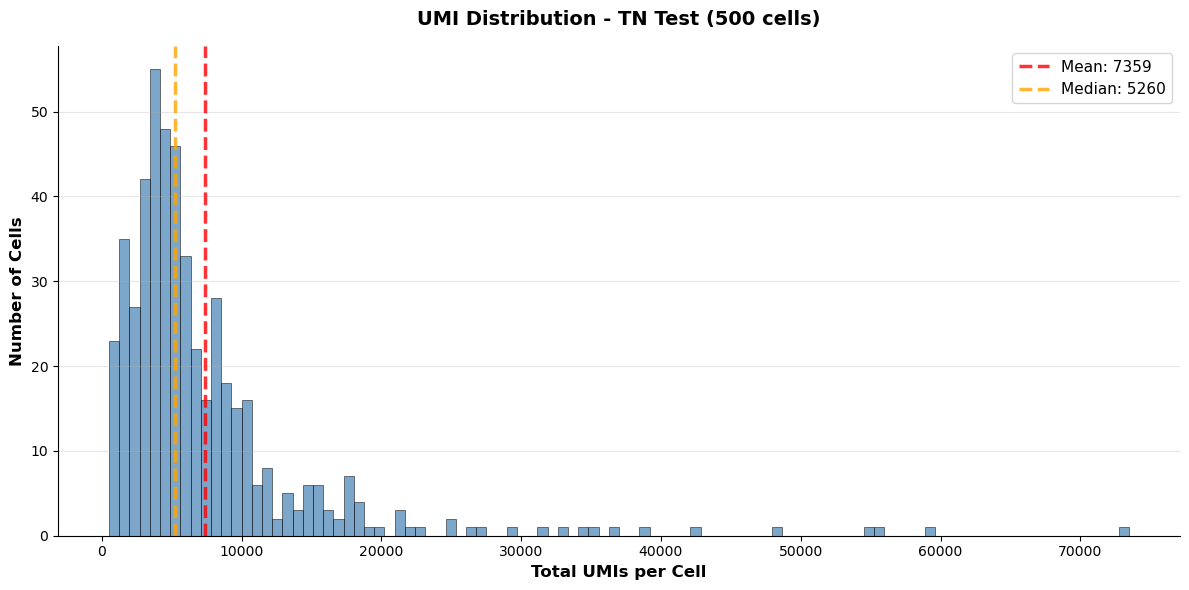

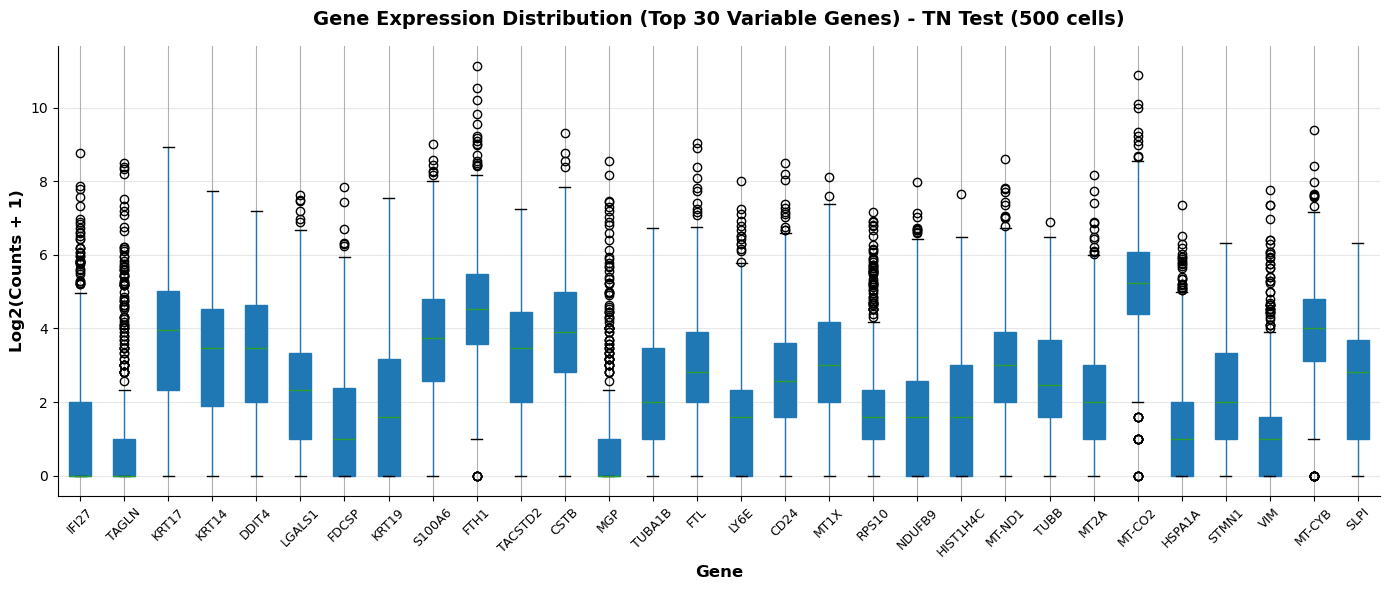

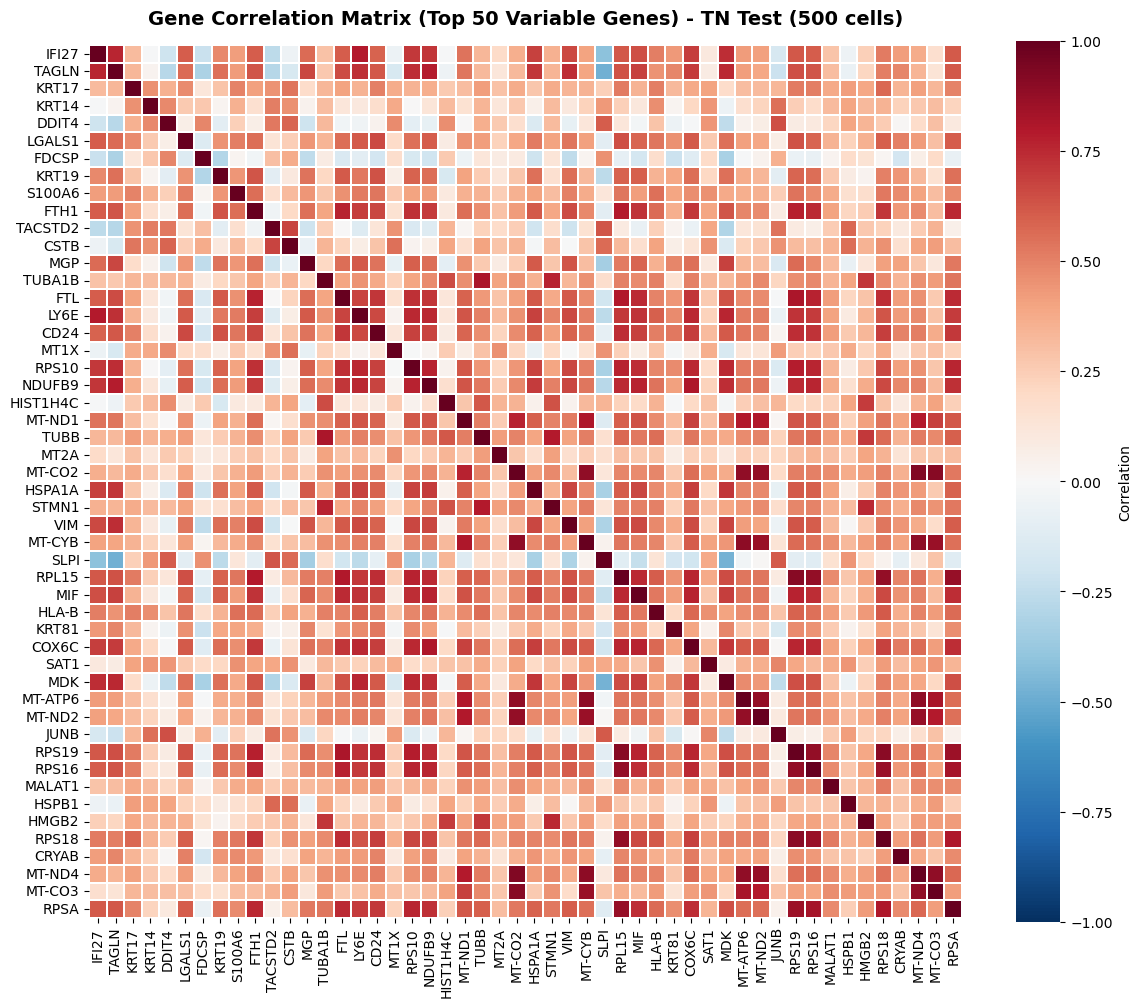

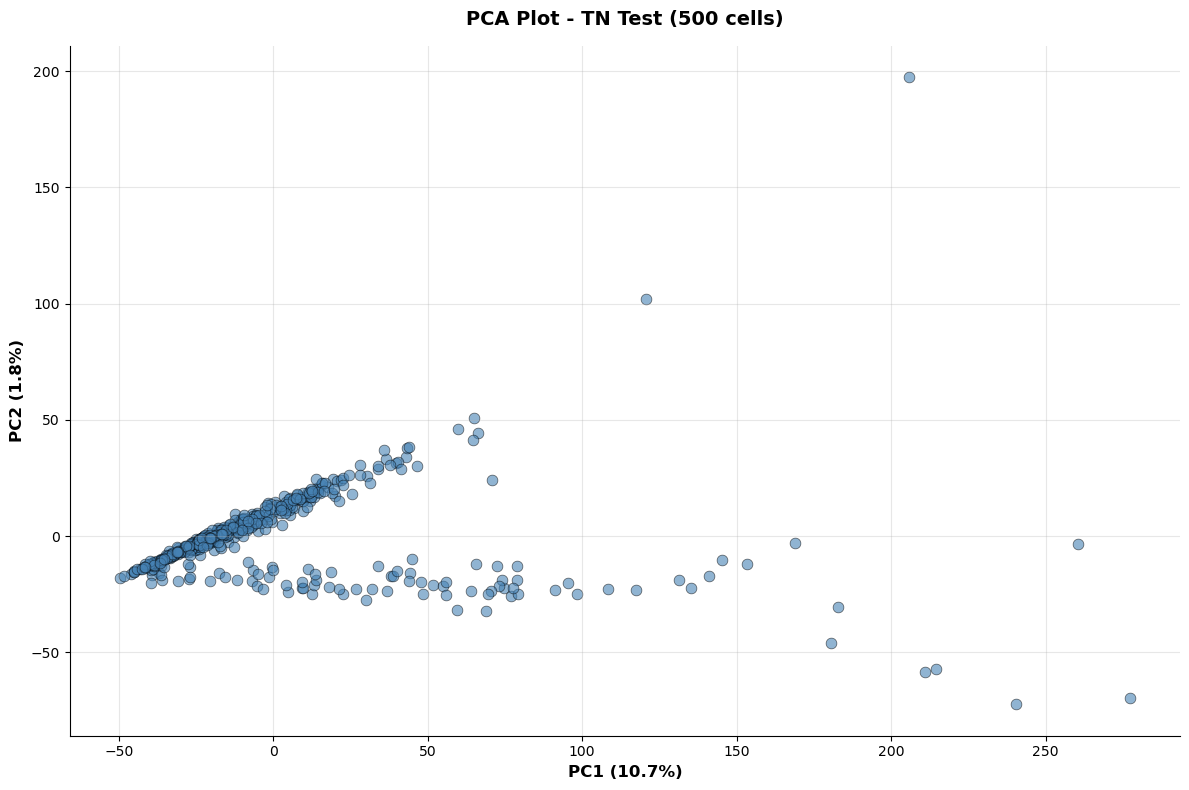

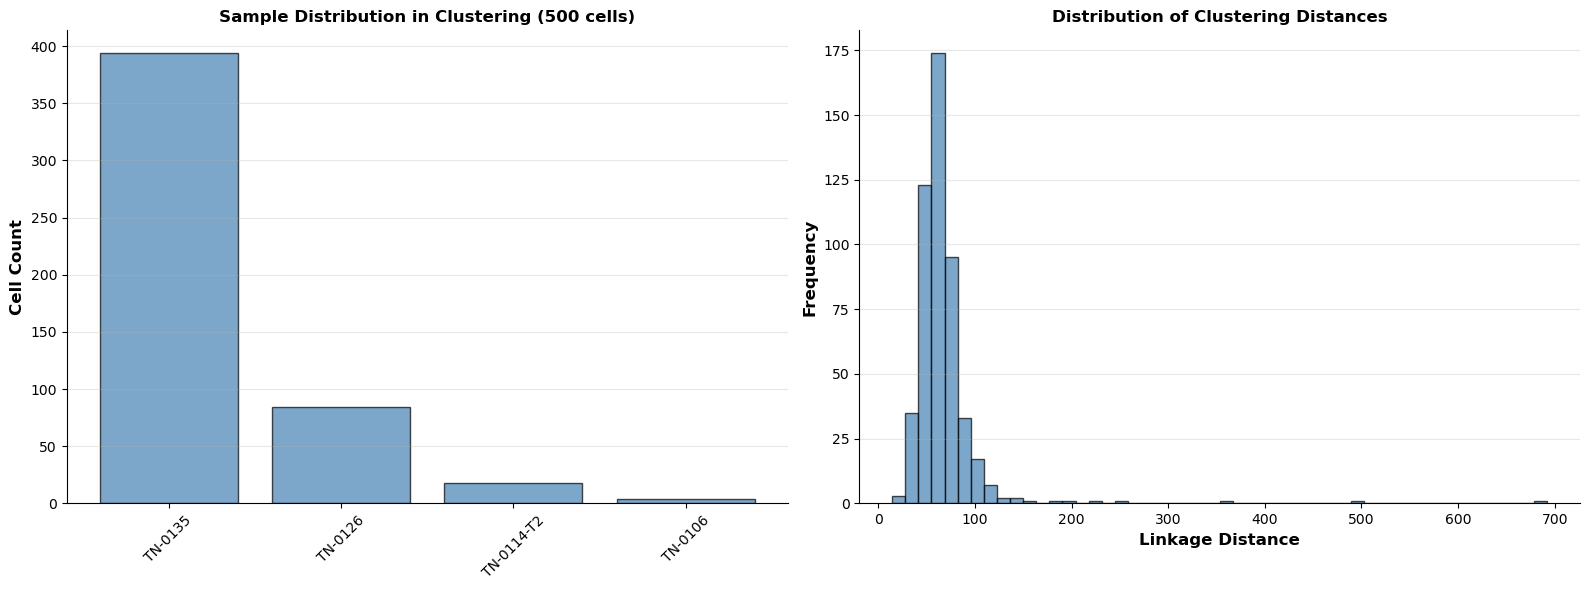

Figure 2: BOXPLOT
Figure 3: CORRELATION
Figure 4: PCA
Figure 5: CLUSTERING_SUMMARY

FULL ANALYSIS: All cells


[EDA] Processing 7,561 cells × 33,514 genes...

[EDA] Creating Figure 1: UMI Distribution...
[EDA] Creating Figure 2: Gene Expression Boxplot...
      Selecting top 30 VARIABLE genes...
      Selected genes: ['IFI27', 'FDCSP', 'KRT17', 'KRT19', 'TAGLN']... (showing first 5)
[EDA] Creating Figure 3: Gene Correlation Heatmap...
[EDA] Creating Figure 4: PCA Plot...
[EDA] Creating Figure 5: Clustering Summary...

[EDA] Calculating QC metrics...

QC METRICS - TN Full (7,561 cells)
Cells:                   7,561
Genes:                  33,514
Total UMIs:         57,242,015
Mean UMIs/cell:         7570.7
Median UMIs/cell:       5326.0
CV UMIs:                 1.131
PC1 variance:             8.2%
PC2 variance:             1.3%

✓ Time: 22.4s

Displaying figures:

Figure 1: UMI_DIST


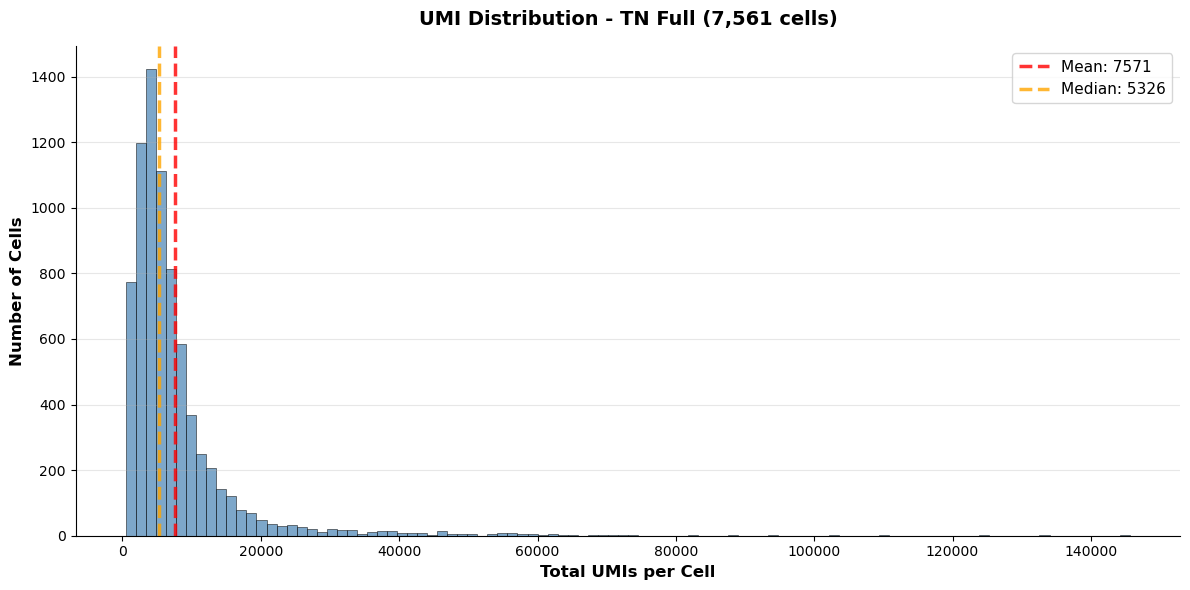

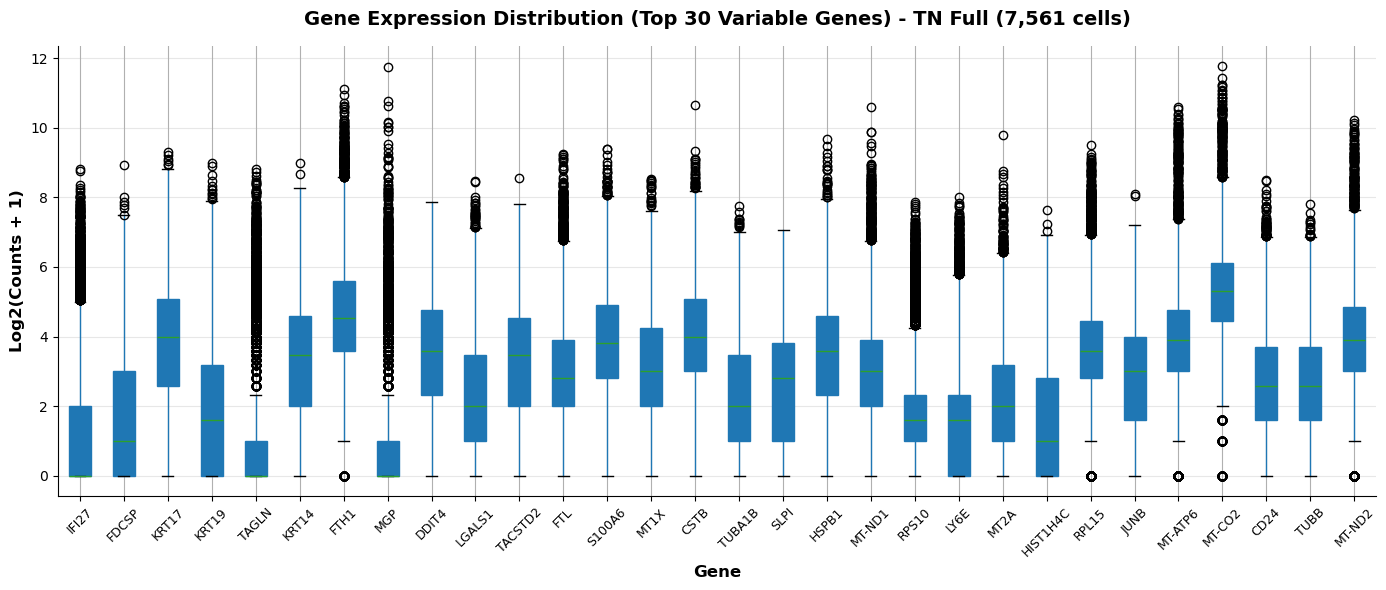

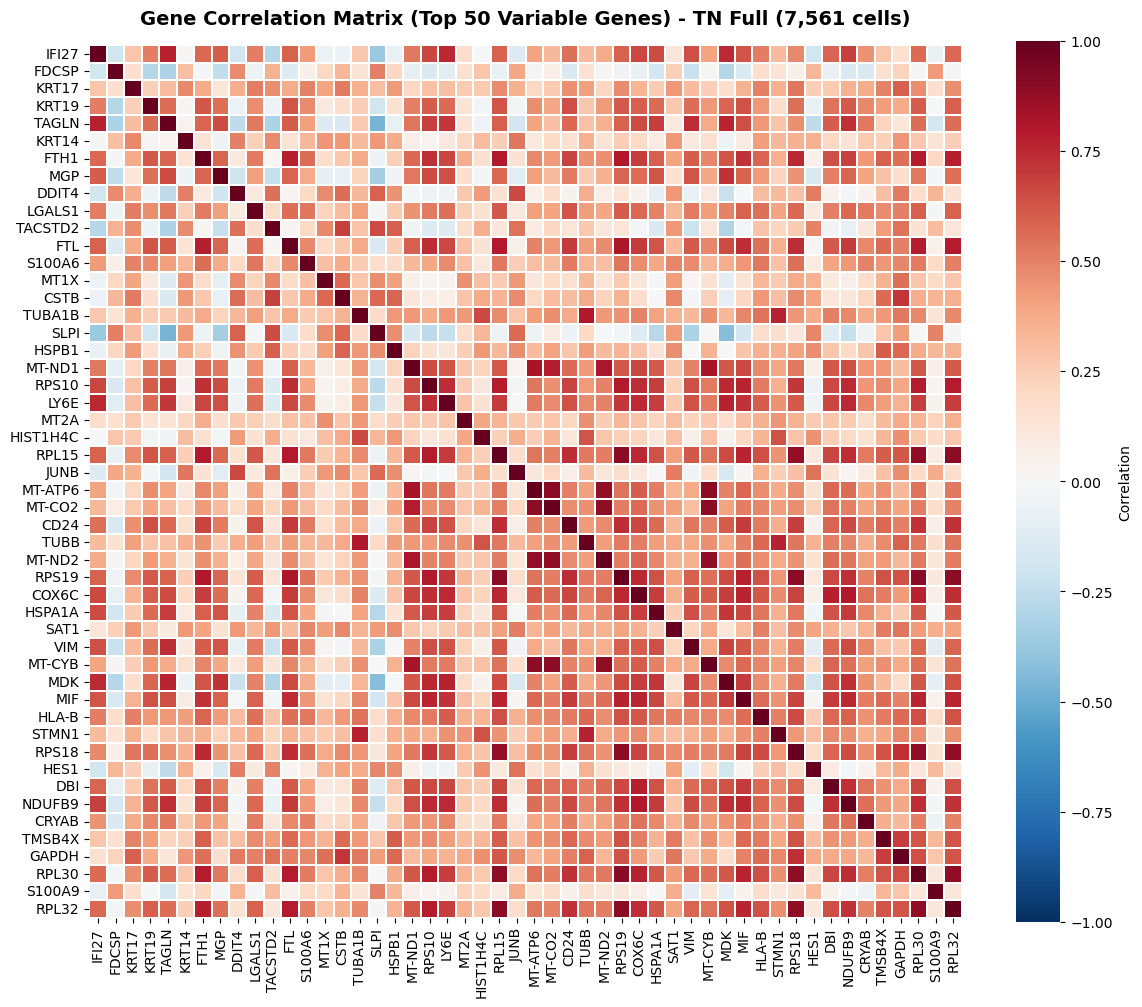

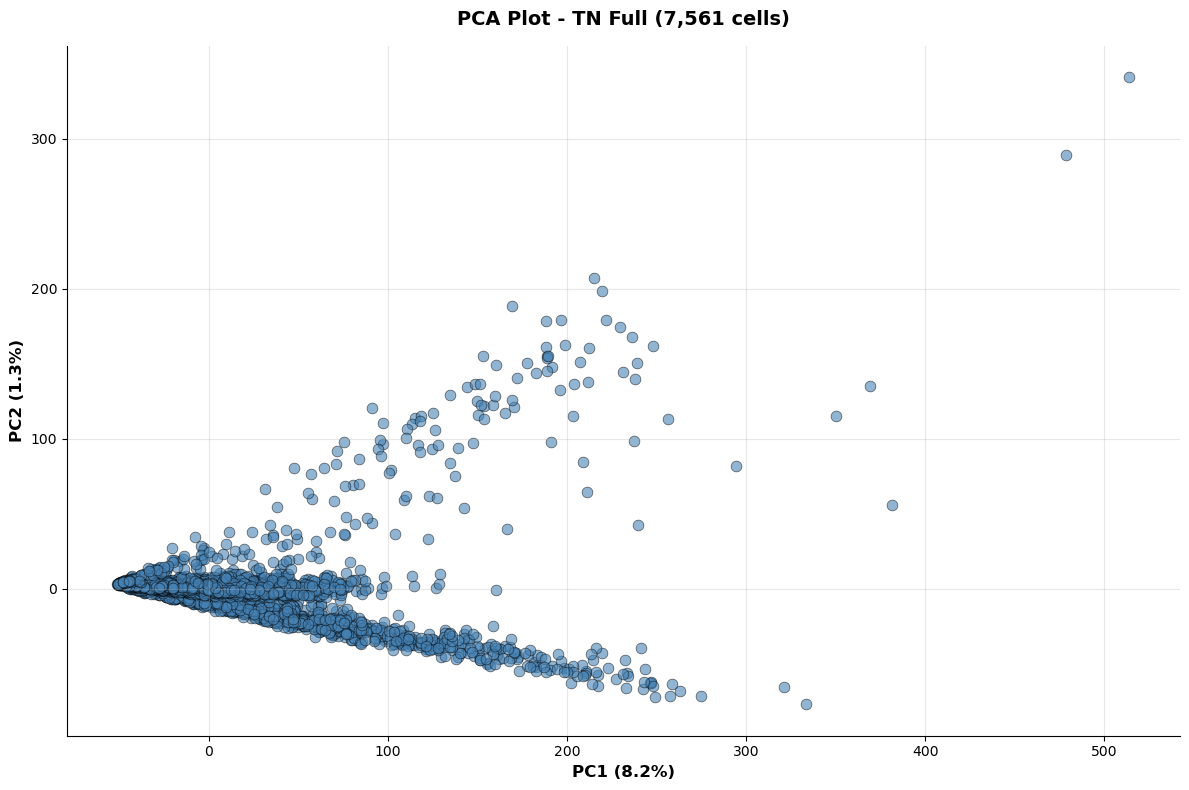

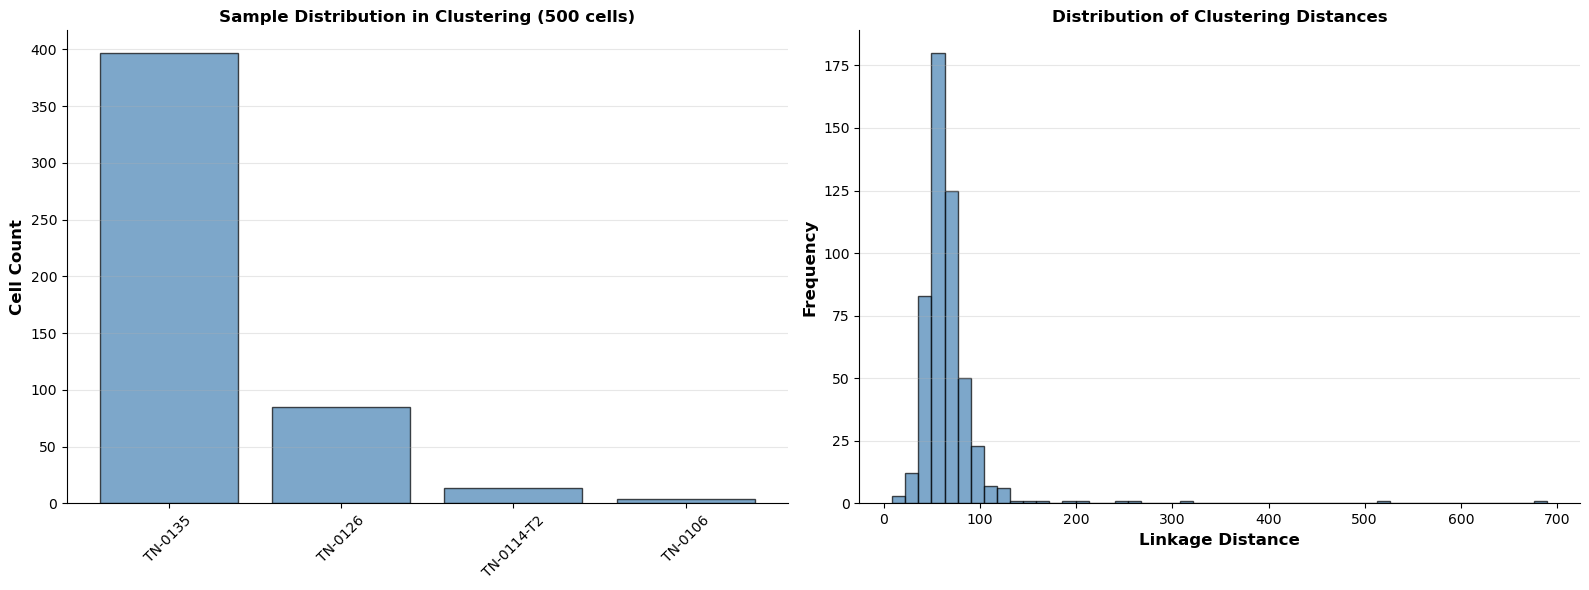

Figure 2: BOXPLOT
Figure 3: CORRELATION
Figure 4: PCA
Figure 5: CLUSTERING_SUMMARY

COMPARISON: Test (500) vs Full (7,561)
Metric               Test (500)           Full (7.5k)         
------------------------------------------------------------
Cells                500                  7,561               
Mean UMIs            7359.3               7570.7              
Median UMIs          5259.5               5326.0              
CV UMIs              1.063                1.131               
PC1 var              10.7%                8.2%                
PC2 var              1.8%                 1.3%                

EDA complete.



In [17]:
def eda_scrnaseq_revised(adata, name, n_genes=30, n_dendro_cells=500):
    """
    Revised EDA - creates SEPARATE figures for better quality visualization
    
    Parameters:
    -----------
    adata: AnnData object
    name: str - dataset name
    n_genes: int - number of TOP VARIABLE genes for boxplot (default 30)
    n_dendro_cells: int - max cells for dendrogram (default 500)
    
    Returns:
    --------
    figures: dict of {fig_name: fig_object}
    stats: dict of QC metrics
    """
    
    print(f"\n{'='*80}")
    print(f"[EDA] Processing {adata.n_obs:,} cells × {adata.n_vars:,} genes...")
    print(f"{'='*80}")
    
    # Convert to dense
    X = adata.X.toarray() if hasattr(adata.X, 'toarray') else adata.X
    df = pd.DataFrame(X, index=adata.obs_names, columns=adata.var_names)
    
    # Core calculations - log transform ONCE
    total_counts = df.sum(axis=1)
    log_df = df.apply(lambda x: np.log2(x + 1))
    
    figures = {}
    
    # ========== FIGURE 1: UMI Distribution (Histogram) ==========
    print(f"\n[EDA] Creating Figure 1: UMI Distribution...")
    fig1 = plt.figure(figsize=(12, 6))
    ax = fig1.add_subplot(111)
    
    ax.hist(total_counts, bins=100, color='steelblue', alpha=0.7, edgecolor='black', linewidth=0.5)
    ax.axvline(total_counts.mean(), color='red', linestyle='--', linewidth=2.5, 
               label=f'Mean: {total_counts.mean():.0f}', alpha=0.8)
    ax.axvline(total_counts.median(), color='orange', linestyle='--', linewidth=2.5,
               label=f'Median: {total_counts.median():.0f}', alpha=0.8)
    
    ax.set_xlabel('Total UMIs per Cell', fontsize=12, fontweight='bold')
    ax.set_ylabel('Number of Cells', fontsize=12, fontweight='bold')
    ax.set_title(f'UMI Distribution - {name}', fontsize=14, fontweight='bold', pad=15)
    ax.legend(fontsize=11, loc='upper right')
    ax.grid(True, alpha=0.3, axis='y')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    figures['umi_dist'] = fig1
    
    # ========== FIGURE 2: Gene Expression Boxplot (Top Variable Genes) ==========
    print(f"[EDA] Creating Figure 2: Gene Expression Boxplot...")
    print(f"      Selecting top {n_genes} VARIABLE genes...")
    
    fig2 = plt.figure(figsize=(14, 6))
    ax = fig2.add_subplot(111)
    
    # Select TOP VARIABLE genes (not random!)
    top_var_genes = log_df.var().nlargest(n_genes).index
    print(f"      Selected genes: {list(top_var_genes[:5])}... (showing first 5)")
    
    # Create boxplot
    log_df[top_var_genes].boxplot(ax=ax, patch_artist=True)
    
    # Style
    for patch in ax.artists:
        patch.set_facecolor('steelblue')
        patch.set_alpha(0.7)
    
    ax.set_xlabel('Gene', fontsize=12, fontweight='bold')
    ax.set_ylabel('Log2(Counts + 1)', fontsize=12, fontweight='bold')
    ax.set_title(f'Gene Expression Distribution (Top {n_genes} Variable Genes) - {name}', 
                 fontsize=14, fontweight='bold', pad=15)
    ax.tick_params(axis='x', rotation=45, labelsize=9)
    ax.grid(True, alpha=0.3, axis='y')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    figures['boxplot'] = fig2
    
    # ========== FIGURE 3: Gene Correlation Heatmap ==========
    print(f"[EDA] Creating Figure 3: Gene Correlation Heatmap...")
    
    fig3 = plt.figure(figsize=(12, 10))
    ax = fig3.add_subplot(111)
    
    top_vars = log_df.var().nlargest(50).index
    corr = log_df[top_vars].corr()
    
    sns.heatmap(corr, cmap='RdBu_r', center=0, vmin=-1, vmax=1, ax=ax, 
                square=True, linewidths=0.2, cbar_kws={'label': 'Correlation'})
    ax.set_title(f'Gene Correlation Matrix (Top 50 Variable Genes) - {name}', 
                 fontsize=14, fontweight='bold', pad=15)
    
    plt.tight_layout()
    figures['correlation'] = fig3
    
    # ========== FIGURE 4: PCA Plot ==========
    print(f"[EDA] Creating Figure 4: PCA Plot...")
    
    fig4 = plt.figure(figsize=(12, 8))
    ax = fig4.add_subplot(111)
    
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(StandardScaler().fit_transform(log_df))
    
    ax.scatter(pca_result[:, 0], pca_result[:, 1], s=60, alpha=0.6, 
              color='steelblue', edgecolors='black', linewidth=0.5)
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=12, fontweight='bold')
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=12, fontweight='bold')
    ax.set_title(f'PCA Plot - {name}', fontsize=14, fontweight='bold', pad=15)
    ax.grid(True, alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    figures['pca'] = fig4
    
    # ========== FIGURE 5: Dendrogram (Cell Clustering) ==========
    print(f"[EDA] Creating Figure 5: Clustering Summary...")

    fig5, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Plot 1: Sample distribution
    n_dendro = min(n_dendro_cells, adata.n_obs)
    idx = np.random.choice(len(df), n_dendro, replace=False)
    sample_counts = adata.obs.iloc[idx]['sample_name'].value_counts()

    axes[0].bar(sample_counts.index, sample_counts.values, color='steelblue', alpha=0.7, edgecolor='black')
    axes[0].set_ylabel('Cell Count', fontsize=12, fontweight='bold')
    axes[0].set_title(f'Sample Distribution in Clustering ({n_dendro} cells)', fontsize=12, fontweight='bold')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(True, alpha=0.3, axis='y')
    axes[0].spines['top'].set_visible(False)
    axes[0].spines['right'].set_visible(False)

    # Plot 2: Distance distribution
    h = linkage(log_df.iloc[idx].values, 'ward')
    axes[1].hist(h[:, 2], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
    axes[1].set_xlabel('Linkage Distance', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
    axes[1].set_title('Distribution of Clustering Distances', fontsize=12, fontweight='bold')
    axes[1].grid(True, alpha=0.3, axis='y')
    axes[1].spines['top'].set_visible(False)
    axes[1].spines['right'].set_visible(False)

    plt.tight_layout()
    figures['clustering_summary'] = fig5
    
    # ========== QC Statistics ==========
    print(f"\n[EDA] Calculating QC metrics...")
    
    stats = {
        'n_cells': adata.n_obs,
        'n_genes': adata.n_vars,
        'total_umis': int(total_counts.sum()),
        'mean_umis': float(total_counts.mean()),
        'median_umis': float(total_counts.median()),
        'cv_umis': float(total_counts.std() / total_counts.mean()),
        'pc1_var': float(pca.explained_variance_ratio_[0]),
        'pc2_var': float(pca.explained_variance_ratio_[1])
    }
    
    print(f"\n{'='*80}")
    print(f"QC METRICS - {name}")
    print(f"{'='*80}")
    print(f"Cells:              {stats['n_cells']:>10,}")
    print(f"Genes:              {stats['n_genes']:>10,}")
    print(f"Total UMIs:         {stats['total_umis']:>10,.0f}")
    print(f"Mean UMIs/cell:     {stats['mean_umis']:>10.1f}")
    print(f"Median UMIs/cell:   {stats['median_umis']:>10.1f}")
    print(f"CV UMIs:            {stats['cv_umis']:>10.3f}")
    print(f"PC1 variance:       {stats['pc1_var']:>10.1%}")
    print(f"PC2 variance:       {stats['pc2_var']:>10.1%}")
    print(f"{'='*80}\n")
    
    return figures, stats


# ============================================================================
# RUN REVISED EDA
# ============================================================================

print("="*80)
print("REVISED EDA: 500 cells (SEPARATE FIGURES)")
print("="*80)

print("\nLoading data...")
tn_path = Path('/triumvirate/home/alexarol/breast_cancer_analysis/results/adata_triplenegative_epithelial_improved.h5ad')
adata_tn = sc.read_h5ad(tn_path)
adata_tn.obs_names_make_unique()

# Test on 500 cells
np.random.seed(42)
idx = np.random.choice(adata_tn.n_obs, min(500, adata_tn.n_obs), replace=False)
adata_test = adata_tn[idx].copy()

print(f"Test subset: {adata_test.n_obs} cells\n")

t0 = time.time()
figs_test, stats_test = eda_scrnaseq_revised(adata_test, "TN Test (500 cells)", n_genes=30)
elapsed = time.time() - t0
print(f"✓ Time: {elapsed:.1f}s\n")

# Display figures
print("Displaying figures:\n")
for i, (fig_name, fig) in enumerate(figs_test.items(), 1):
    print(f"Figure {i}: {fig_name.upper()}")
    plt.show()

# ============================================================================
# FULL ANALYSIS
# ============================================================================

proceed = input("\nRun full analysis on all 7,561 cells? (yes/no): ").strip().lower()

if proceed in ['yes', 'y']:
    print("\n" + "="*80)
    print("FULL ANALYSIS: All cells")
    print("="*80 + "\n")
    
    t0 = time.time()
    figs_full, stats_full = eda_scrnaseq_revised(adata_tn, "TN Full (7,561 cells)", n_genes=30)
    elapsed = time.time() - t0
    print(f"✓ Time: {elapsed:.1f}s\n")
    
    # Display figures
    print("Displaying figures:\n")
    for i, (fig_name, fig) in enumerate(figs_full.items(), 1):
        print(f"Figure {i}: {fig_name.upper()}")
        plt.show()
    
    # Comparison table
    print(f"\n{'='*80}")
    print("COMPARISON: Test (500) vs Full (7,561)")
    print(f"{'='*80}")
    print(f"{'Metric':<20} {'Test (500)':<20} {'Full (7.5k)':<20}")
    print(f"{'-'*60}")
    print(f"{'Cells':<20} {stats_test['n_cells']:<20,} {stats_full['n_cells']:<20,}")
    print(f"{'Mean UMIs':<20} {stats_test['mean_umis']:<20.1f} {stats_full['mean_umis']:<20.1f}")
    print(f"{'Median UMIs':<20} {stats_test['median_umis']:<20.1f} {stats_full['median_umis']:<20.1f}")
    print(f"{'CV UMIs':<20} {stats_test['cv_umis']:<20.3f} {stats_full['cv_umis']:<20.3f}")
    print(f"{'PC1 var':<20} {stats_test['pc1_var']:<20.1%} {stats_full['pc1_var']:<20.1%}")
    print(f"{'PC2 var':<20} {stats_test['pc2_var']:<20.1%} {stats_full['pc2_var']:<20.1%}")
    print(f"{'='*80}\n")
    
    print("EDA complete.")
else:
    print("\nStopped.\n")

print("="*80 + "\n")


[EDA] Processing 7,561 cells × 33,514 genes...
[EDA] Creating Figure 1B: Total Counts per Sample...


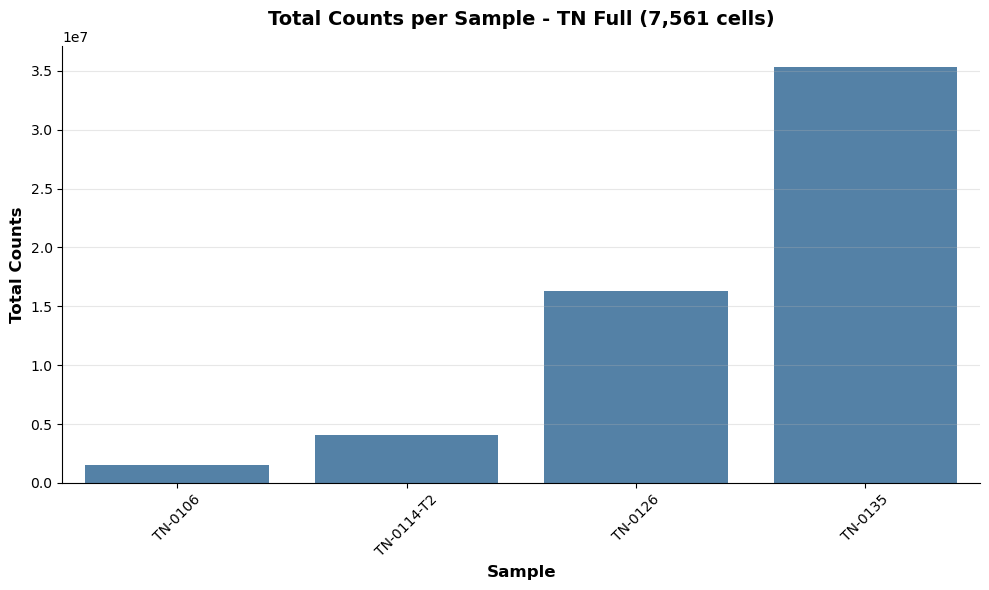

In [10]:
print(f"\n{'='*80}")
print(f"[EDA] Processing {adata_tn.n_obs:,} cells × {adata_tn.n_vars:,} genes...")
print(f"{'='*80}")

# Convert to dense
X = adata_tn.X.toarray() if hasattr(adata_tn.X, 'toarray') else adata_tn.X
df = pd.DataFrame(X, index=adata_tn.obs_names, columns=adata_tn.var_names)

# Core calculations
total_counts = df.sum(axis=1)

print(f"[EDA] Creating Figure 1B: Total Counts per Sample...")

fig1b = plt.figure(figsize=(10, 6))
ax = fig1b.add_subplot(111)

# Group cells by sample and sum counts
sample_totals = df.groupby(adata_tn.obs['sample_name']).sum().sum(axis=1)

sns.barplot(x=sample_totals.index, y=sample_totals.values, color='steelblue', ax=ax)
ax.set_xlabel('Sample', fontsize=12, fontweight='bold')
ax.set_ylabel('Total Counts', fontsize=12, fontweight='bold')
ax.set_title('Total Counts per Sample - TN Full (7,561 cells)', fontsize=14, fontweight='bold', pad=15)
ax.tick_params(axis='x', rotation=45, labelsize=10)
ax.grid(True, alpha=0.3, axis='y')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

The TN dataset is dominated by sample TN-0135 (6,111 cells, 80.8%), with smaller contributions from TN-0126 (1,167 cells), TN-0114-T2 (227 cells), and TN-0106 (56 cells). 

While this creates an imbalanced design, all samples show consistent quality metrics (median 5,326 UMIs/cell). 

Results may preferentially reflect biology from the dominant sample.

Next step they have in SmallSeqFlow is the Quality Control, Filtering, and Normalization this way: 

- SmallSeqFlow filters by CPM because:

- They work with bulk samples (few columns)

- Low-expression genes add noise


my data is scRNA--seq data, so i shoudl use different approach, thats why i will uyse the RECODE. https://github.com/yusuke-imoto-lab/RECODE

In [18]:
pip install screcode

  Using cached screcode-2.2.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached adjustText-1.3.0-py3-none-any.whl.metadata (3.1 kB)
  Using cached datetime-6.0-py3-none-any.whl.metadata (34 kB)
Using cached screcode-2.2.0-py3-none-any.whl (18 kB)
Using cached adjustText-1.3.0-py3-none-any.whl (13 kB)
Using cached datetime-6.0-py3-none-any.whl (52 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [screcode]1/4 [datetime]
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install screcode

Note: you may need to restart the kernel to use updated packages.


In [6]:
import scanpy as sc
import screcode
import numpy as np
import pandas as pd
from pathlib import Path

print("RUNNING RECODE ON ALL 6 DATASETS (10x H5 → denoised + RECODE-chosen genes)")

base = Path("/triumvirate/home/alexarol/breast_cancer_analysis")
matrix_dir = base / "results" / "10x_filtered_feature_bc_matrix"
out_dir = base / "results" / "recode_outputs"
out_dir.mkdir(exist_ok=True, parents=True)

datasets = {
    "Normal":        "normal_10x_filtered_feature_bc_matrix.h5",
    "ER_Positive":   "erpos_10x_filtered_feature_bc_matrix.h5",
    "HER2_Positive": "her2_10x_filtered_feature_bc_matrix.h5",
    "TN":            "tn_10x_filtered_feature_bc_matrix.h5",
    "TN_BRCA1":      "tn_brca1_10x_filtered_feature_bc_matrix.h5",
    "Preneoplastic": "preneo_10x_filtered_feature_bc_matrix.h5",
}

for label, fname in datasets.items():
    in_path = matrix_dir / fname
    if not in_path.exists():
        print(f"\n[SKIP] {label}: {in_path} not found")
        continue

    print("\n" + "-"*80)
    print(f"[{label}] Input: {in_path.name}")
    print("-"*80)

    # 1) Read 10x H5
    adata = sc.read_10x_h5(in_path)
    adata.var_names_make_unique()
    adata.obs_names_make_unique()
    print(f"   Loaded: {adata.n_obs:,} cells × {adata.n_vars:,} genes")

    # 2) Run RECODE
    print("   Starting RECODE.")
    recode = screcode.RECODE(
        assay="RNA",
        version=2,
        solver="randomized",   # force randomized solver
        downsampling_rate=0.1, # use 10% of cells for SVD step
        fast_algorithm=True,
        log_normalize=True,
        target_sum=1e5,
        verbose=True,
)
    adata_recode = recode.fit_transform(adata)
    print("   RECODE finished.")

    # 3) Extract denoised matrix & RECODE-selected genes
    if "RECODE" not in adata_recode.obsm:
        raise KeyError("RECODE output missing in adata_recode.obsm['RECODE']")

    X_denoised = adata_recode.obsm["RECODE"]  # cells × genes
    denoised_df = pd.DataFrame(
        X_denoised.T,
        index=adata_recode.var_names,
        columns=adata_recode.obs_names,
    )

    if "significance_RECODE" not in adata_recode.var.columns:
        raise KeyError("significance_RECODE missing in adata_recode.var")

    sig = adata_recode.var["significance_RECODE"].astype(str)
    hvg_mask = sig == "significant"
    hvg_genes = adata_recode.var_names[hvg_mask]
    print(f"   RECODE significant genes: {hvg_mask.sum()} (used as HVGs)")

    # 4) Save outputs
    # (a) full denoised matrix (genes × cells)
    den_path = out_dir / f"{label}_RECODE_denoised_genesxcells.csv"
    denoised_df.to_csv(den_path)
    print(f"   Saved denoised matrix: {den_path.name}")

    # (b) significant genes only (genes × cells)
    denoised_hvg_df = denoised_df.loc[hvg_genes]
    hvg_mat_path = out_dir / f"{label}_RECODE_sig_genes_genesxcells.csv"
    denoised_hvg_df.to_csv(hvg_mat_path)
    print(f"   Saved RECODE-selected gene matrix: {hvg_mat_path.name}")

    # (c) WGCNA input: cells × genes
    wgcna_path = out_dir / f"{label}_RECODE_sig_genes_cellsxgenes_forWGCNA.csv"
    denoised_hvg_df.T.to_csv(wgcna_path)
    print(f"  Saved WGCNA input: {wgcna_path.name}")

    # (d) Gene-level stats
    norm_var_col = (
        "normalized_variance_RECODE"
        if "normalized_variance_RECODE" in adata_recode.var.columns
        else None
    )
    cols = {"gene": adata_recode.var_names, "significance_RECODE": sig.values}
    if norm_var_col:
        cols[norm_var_col] = adata_recode.var[norm_var_col].values

    hvg_stats = pd.DataFrame(cols)
    hvg_stats_path = out_dir / f"{label}_RECODE_gene_stats.csv"
    hvg_stats.to_csv(hvg_stats_path, index=False)
    print(f"  ✓ Saved gene stats: {hvg_stats_path.name}")

print("\nAll available datasets processed with RECODE.")

RUNNING RECODE ON ALL 6 DATASETS (10x H5 → denoised + RECODE-chosen genes)

--------------------------------------------------------------------------------
[Normal] Input: normal_10x_filtered_feature_bc_matrix.h5
--------------------------------------------------------------------------------
   Loaded: 83,522 cells × 33,514 genes
   Starting RECODE.
start RECODE for scRNA-seq data


KeyboardInterrupt: 

The crash almost certainly means the RECODE run exhausted RAM or CPU resources on that node, not that there is a syntax bug.

Given your sizes:

Normal: ~83,522 cells

ER+ : ~91,908 cells

RECODE (PCA, SVD, eigenvector estimation) on full dense matrices of shape 
≈ 10 5 cells
×
3
⋅
10
4
 genes
≈10 
5
  cells×3⋅10 
4
  genes is extremely heavy; converting the sparse 10x matrix to dense inside RECODE can easily exceed tens of GB of RAM and kill the kernel.

so my problem: 2 of 6 datasets are too big (normal and er_positive, they have too many cells). becasue of this instead of direcly using the RECODE to denoise my dataset i will be creating a helper function which will determine the amount of cells.

if more then 30 000 cells, i will perform subsampling of the sample. what i know from their article is: Our GitHub repository for RECODE defaults to a 20% downsampling rate for datasets exceeding 20,000 samples.

One “main” cell that:
- Imports things.
- Defines a small helper class/function to:
- Optionally subsample if n_cells > 30_000.
- Run RECODE.
- Return key outputs (denoised adata, significant genes, gene stats).
- Does not start any analysis yet.
- Then you can have separate cells for each dataset (Normal, ER_Positive, etc.) where you call this helper with full control.

okay, i have completed the RECODE analysis in the separate 06_recode.ipynb; now i have al the denoisedd matrices. here i will proceed furthe with SmallSeqFlow using the data generated in recode notebook

In [ ]:
#looking into one of the outputs (the smallest one)

import pandas as pd
import numpy as np

path = "/triumvirate/home/alexarol/breast_cancer_analysis/results/recode_outputs/tn/TN_RECODE_sig_genes_cellsxgenes_forWGCNA.csv"
df = pd.read_csv(path)

print("Shape (rows, columns):", df.shape)
print("\nColumn dtypes:")
print(df.dtypes)

print("\nHead:")
print(df.head())

first_col = df.columns[0]
if not np.issubdtype(df[first_col].dtype, np.number):
    gene_names = df[first_col]
    expr = df.iloc[:, 1:]
else:
    gene_names = None
    expr = df

print("\nExpression submatrix shape:", expr.shape)

zero_count = (expr == 0).sum().sum()
total_entries = expr.size
zero_frac = zero_count / total_entries
print(f"\nSparsity in expression part: {zero_frac:.3f} (zeros: {zero_count} / {total_entries})")

print("\nTotal expression per cell (first 10 columns):")
print(expr.sum(axis=0).head(10))

print("\nTotal expression per gene (first 10 genes):")
print(expr.sum(axis=1).head(10))

print("\nBasic stats for expression values:")
print(expr.describe())

/triumvirate/apps/.scratch/alexarol/ipykernel_20874/417187917.py:7: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


Shape (rows, columns): (7561, 16381)

Column dtypes:
Unnamed: 0    object
AL627309.1     int64
AL669831.5     int64
LINC00115      int64
FAM41C         int64
               ...  
BX004987.1     int64
AC011043.1     int64
AC007325.4     int64
AL354822.1     int64
AC004556.1     int64
Length: 16381, dtype: object

Head:
  Unnamed: 0  AL627309.1  AL669831.5  LINC00115  FAM41C  AL645608.3  \
0          0           0           0          0       1           0   
1          2           0           0          0       0           0   
2          4           0           0          0       0           0   
3          9           0           0          0       0           0   
4         15           0           1          0       0           0   

   AL645608.1  SAMD11  NOC2L  PLEKHN1  ...  MT-ND4L  MT-ND4  MT-ND5  MT-ND6  \
0           0       0      1        0  ...        5     184      30       0   
1           0       0      0        0  ...        0      43       1       1   
2           0   

In [4]:
#just checking something, i would do more stuff later adn not use these prints

import pandas as pd
import numpy as np

path = "/triumvirate/home/alexarol/breast_cancer_analysis/results/recode_outputs/tn/TN_RECODE_sig_genes_cellsxgenes_forWGCNA.csv"

df = pd.read_csv(path, dtype={0: str})
cell_ids = df.iloc[:, 0].astype(str)
expr = df.iloc[:, 1:]
expr.index = cell_ids  # rows = cells, columns = genes

#Gene-wise variance
gene_var = expr.var(axis=0)
top_k = 3000
hvg_genes = gene_var.sort_values(ascending=False).head(top_k).index

expr_hvg = expr[hvg_genes]
print("HVG matrix shape:", expr_hvg.shape)

#check sparsity after HVG filtering
zero_frac_hvg = (expr_hvg == 0).sum().sum() / expr_hvg.size
print("Sparsity in HVG matrix:", zero_frac_hvg)

#check density after HVG filtering
sparsity = zero_frac_hvg  # your value for expr_hvg
density = 1.0 - sparsity
print("Density:", density)

HVG matrix shape: (7561, 3000)
Sparsity in HVG matrix: 0.5674243265881938
Density: 0.43257567341180625


# SECTION 2: Filter to Highly Variable Genes (HVGs)

WHY:
- reduce 33,514 genes to ~3,000 HVGs
- keep only genes that vary (show cell identity)
- improve network quality and computational speed

DATA:
- raw expression data (log-transformed, from Phase 2)

OUTPUT:
- HVG-filtered datasets saved with _phase3_hvg suffix

NEXT USE:
- HVG-filtered data input to WGCNA

Why Filter to HVGs?
**What are HVGs?**
- Genes that vary a lot across cells (high variance)
- vs. "housekeeping genes" that are expressed in all cells equally

**Why filter?**
- 33,514 genes → only ~3,000 HVGs are meaningful for networks
- HVGs show cell identity and subtype differences
- Reduces noise, improves network quality
- Computational efficiency (faster WGCNA)

**What I do:**
- Calculate gene variance across all cells
- Select top 3,000 (or by threshold)
- Keep only these for network analysis

In [2]:
print(f'{"SECTION 2: FILTER TO HIGHLY VARIABLE GENES":^80}\n')

def select_hvgs(adata, n_hvgs=3000):
    '''identify highly variable genes using variance criterion'''
    #calculated variance per gene
    gene_var = np.asarray(adata.X.power(2).mean(axis=0)) - np.asarray(adata.X.mean(axis=0))**2
    gene_var = np.array(gene_var).flatten()
    
    #selected top n genes by variance
    hvg_idx = np.argsort(gene_var)[-n_hvgs:]
    
    #subset to HVGs
    adata_hvg = adata[:, hvg_idx].copy()
    
    return adata_hvg, len(hvg_idx)

print(f'selecting highly variable genes (HVGs)...\n')
print(f'target: {WGCNA_PARAMS["min_module_size"]*100} genes for robust networks\n')

hvg_summary = {}
for group_name, file_path in epithelial_files.items():
    print(f'{group_name:25}', end=' ', flush=True)
    
    #loaded epithelial data
    adata = sc.read_h5ad(file_path)
    
    #filtered to HVGs
    adata_hvg, n_hvgs = select_hvgs(adata, n_hvgs=3000)
    
    #saved HVG-filtered data
    out_file = PHASE3_DIR / f'adata_{group_name.lower()}_epithelial_phase3_hvg.h5ad'
    adata_hvg.write(out_file)
    
    hvg_summary[group_name] = {
        'total_genes': adata.n_vars,
        'hvg_selected': n_hvgs,
        'cells': adata.n_obs,
        'file': out_file.name,
    }
    
    print(f'OK {adata.n_obs:,} cells × {n_hvgs} HVGs')

print(f'\nOK HVG filtering complete\n')

                   SECTION 2: FILTER TO HIGHLY VARIABLE GENES                   

selecting highly variable genes (HVGs)...

target: 3000 genes for robust networks

Normal                    OK 83,522 cells × 3000 HVGs
ER_Positive               OK 91,908 cells × 3000 HVGs
HER2_Positive             OK 19,693 cells × 3000 HVGs
TripleNegative            OK 7,561 cells × 3000 HVGs
TripleNegative_BRCA1      OK 14,186 cells × 3000 HVGs

OK HVG filtering complete



# SECTION 3: DEFINE WGCNA FUNCTIONS

WHY:
- create reusable functions for WGCNA pipeline
- DRY principle: write once, use many times

DATA:
- HVG-filtered expression data
- correlation matrices

OUTPUT:
- 4 production-ready functions

NEXT USE:
- called in SECTION 5 (testing) and SECTION 6 (full pipeline)

for soft power: 
- Apply a threshold to adjacency (ignore tiny correlations)
- Use connectivity (weighted degree) NOT binary degree
- Use proper scale-free calculation

SOLUTION: 
- Uses connectivity (weighted degree) - how strongly connected each gene is
- Uses n_connections (binary degree) - how many genes it connects to (above threshold)
- Applies threshold (0.001) - ignores tiny correlations that aren't real
- Filters bottom 5% - removes isolated nodes that skew the plot
- Proper log-log regression - on meaningful data

Old version:
- Tried to build TOM (topological overlap matrix) → too complex, failed silently
- Fell back to KMeans with wrong cluster number

New version:
- Simpler approach: use euclidean distance on adjacency matrix
- Hierarchical clustering with ward method (more robust)
- Better estimate of n_clusters: int(genes / (min_module_size * 2))
- For 3,000 genes: 3000 / (30 * 2) = 50 clusters ✓ (not 3,000!)
- Better error handling with fallback to KMeans

In [23]:
print(f'{"SECTION 3: DEFINE WGCNA FUNCTIONS":^80}\n')

def calculate_soft_power_fit(correlation_matrix, power_range):
    '''calculate scale-free fit R² for range of soft powers (β)'''
    fit_results = []
    
    for power in power_range:
        #raised absolute correlations to power
        adjacency = np.abs(correlation_matrix) ** power
        
        #calculated weighted connectivity (sum of edges per node)
        connectivity = adjacency.sum(axis=1)
        
        #calculated number of connections above threshold (0.001)
        threshold = 0.001
        n_connections = (adjacency > threshold).sum(axis=1)
        
        #filtered for nodes with connections
        valid_mask = connectivity > 0
        if valid_mask.sum() < 10:
            fit_results.append({'power': power, 'r_squared': 0.0})
            continue
        
        k = connectivity[valid_mask]
        p_k = n_connections[valid_mask]
        
        #removed nodes with very low connectivity
        min_k = np.percentile(k, 5)  #bottom 5%
        valid_mask2 = k > min_k
        
        if valid_mask2.sum() < 10:
            fit_results.append({'power': power, 'r_squared': 0.0})
            continue
        
        k = k[valid_mask2]
        p_k = p_k[valid_mask2]
        
        try:
            #log-log fit
            log_k = np.log10(k)
            log_pk = np.log10(p_k + 1)  #add 1 to avoid log(0)
            
            #removed any invalid values
            valid = ~(np.isnan(log_k) | np.isnan(log_pk) | np.isinf(log_k) | np.isinf(log_pk))
            
            if valid.sum() < 10:
                fit_results.append({'power': power, 'r_squared': 0.0})
                continue
            
            #linear regression
            slope, intercept, r_value, _, _ = stats.linregress(log_k[valid], log_pk[valid])
            r_squared = r_value ** 2
            
        except:
            r_squared = 0.0
        
        fit_results.append({'power': power, 'r_squared': r_squared})
    
    return pd.DataFrame(fit_results)


def build_adjacency_matrix(correlation_matrix, soft_power):
    '''construct adjacency matrix (network edges) using soft power threshold'''
    adjacency = np.abs(correlation_matrix) ** soft_power
    return adjacency


def detect_modules(adjacency_matrix, min_module_size=30, deep_split=2):
    '''identify co-expressed gene modules using simple clustering'''
    
    #calculated connectivity
    connectivity = adjacency_matrix.sum(axis=1)
    
    #removed isolated genes (very low connectivity)
    threshold = np.percentile(connectivity, 10)  #bottom 10%
    valid_mask = connectivity > threshold
    
    if valid_mask.sum() < 100:
        #fallback: simple assignment
        n_modules = max(5, int(adjacency_matrix.shape[0] / min_module_size))
        from sklearn.cluster import KMeans
        adj_clean = np.nan_to_num(adjacency_matrix, nan=0, posinf=0, neginf=0)
        try:
            clusters = KMeans(n_clusters=n_modules, random_state=42, n_init=10).fit_predict(adj_clean) + 1
        except:
            clusters = np.ones(adjacency_matrix.shape[0], dtype=int)
        return clusters, adjacency_matrix
    
    #subset adjacency to valid genes
    adj_subset = adjacency_matrix[np.ix_(valid_mask, valid_mask)]
    
    #simple clustering: use correlation-based distance
    from scipy.cluster.hierarchy import linkage, fcluster
    from scipy.spatial.distance import pdist
    
    try:
        #calculated pairwise distances from adjacency (similarity → distance)
        distances = pdist(adj_subset, metric='euclidean')
        
        #check distances are valid
        if not np.all(np.isfinite(distances)):
            distances = np.nan_to_num(distances, nan=1.0, posinf=1.0, neginf=0.0)
        
        #hierarchical clustering
        Z = linkage(distances, method='ward')
        
        #cut dendrogram to get modules
        #estimate number of modules from data size
        n_modules = max(5, int(adj_subset.shape[0] / (min_module_size * 2)))
        clusters_subset = fcluster(Z, n_modules, criterion='maxclust')
        
    except Exception as e:
        #fallback: simple k-means
        n_modules = max(5, int(adj_subset.shape[0] / (min_module_size * 2)))
        from sklearn.cluster import KMeans
        try:
            clusters_subset = KMeans(n_clusters=n_modules, random_state=42, n_init=10).fit_predict(adj_subset) + 1
        except:
            clusters_subset = np.ones(adj_subset.shape[0], dtype=int)
    
    #mapped back to original gene indices
    clusters = np.ones(adjacency_matrix.shape[0], dtype=int)
    clusters[valid_mask] = clusters_subset
    
    return clusters, adjacency_matrix

def identify_hub_genes(adjacency_matrix, module_assignment, top_n=10):
    '''rank genes by within-module connectivity (hub genes)'''
    hub_genes = {}
    
    for module_id in np.unique(module_assignment):
        if module_id == 0:  #skip unassigned genes
            continue
        
        module_mask = module_assignment == module_id
        module_genes = np.where(module_mask)[0]
        
        if len(module_genes) < 3:
            continue
        
        #calculated within-module connectivity
        module_adj = adjacency_matrix[np.ix_(module_genes, module_genes)]
        connectivity = module_adj.sum(axis=1)
        
        #ranked by connectivity
        top_idx = np.argsort(connectivity)[-top_n:][::-1]
        hub_genes[f'module_{module_id}'] = module_genes[top_idx]
    
    return hub_genes

print(f'OK functions defined:')
print(f'  - calculate_soft_power_fit()')
print(f'  - build_adjacency_matrix()')
print(f'  - detect_modules()')
print(f'  - identify_hub_genes()\n')

                       SECTION 3: DEFINE WGCNA FUNCTIONS                        

OK functions defined:
  - calculate_soft_power_fit()
  - build_adjacency_matrix()
  - detect_modules()
  - identify_hub_genes()



# SECTION 4: Soft Power Detection
WHY:
- find optimal soft power (β) for each epithelial group
- different tissues have different optimal values
- ensures biologically meaningful networks

DATA:
- HVG-filtered expression (3,000 genes)

OUTPUT:
- soft power selection table + visualizations

NEXT USE:
- optimal soft power used in SECTION 6 full pipeline

In [18]:

print(f'{"SECTION 4: SOFT POWER DETECTION":^80}\n')

print(f'detecting optimal soft power for each group\n')
print(f'(this analyzes scale-free network properties)\n')

soft_power_results = {}

for group_name, file_path in epithelial_files.items():
    print(f'{group_name:25}', end=' ', flush=True)
    
    #loaded HVG data
    hvg_file = PHASE3_DIR / f'adata_{group_name.lower()}_epithelial_phase3_hvg.h5ad'
    adata_hvg = sc.read_h5ad(hvg_file)
    
    #calculated correlation matrix
    expr_matrix = adata_hvg.X.toarray() if hasattr(adata_hvg.X, 'toarray') else adata_hvg.X
    corr_matrix = np.corrcoef(expr_matrix.T)
    
    #detected soft power
    fit_df = calculate_soft_power_fit(corr_matrix, WGCNA_PARAMS['soft_power_range'])
    
    #selected power where R² > threshold
    threshold = WGCNA_PARAMS['r_squared_threshold']
    valid_powers = fit_df[fit_df['r_squared'] > threshold]
    
    if len(valid_powers) > 0:
        optimal_power = valid_powers.iloc[0]['power']
        optimal_r2 = valid_powers.iloc[0]['r_squared']
    else:
        #fallback: choose maximum R²
        optimal_idx = fit_df['r_squared'].idxmax()
        optimal_power = fit_df.loc[optimal_idx, 'power']
        optimal_r2 = fit_df.loc[optimal_idx, 'r_squared']
    
    soft_power_results[group_name] = {
        'soft_power': optimal_power,
        'r_squared': optimal_r2,
        'fit_table': fit_df,
    }
    
    print(f'OK β={optimal_power}, R²={optimal_r2:.3f}')

print(f'\nOK soft power detection complete\n')

#displayed summary
print(f'SOFT POWER SUMMARY:')
print(f'{"Group":25} {"Soft Power (β)":20} {"R² (scale-free fit)":20}')
print(f'{"-"*65}')
for group_name, result in soft_power_results.items():
    print(f'{group_name:25} {result["soft_power"]:20.0f} {result["r_squared"]:20.4f}')

print(f'\n')

                        SECTION 4: SOFT POWER DETECTION                         

detecting optimal soft power for each group

(this analyzes scale-free network properties)

Normal                    OK β=30, R²=0.748
ER_Positive               OK β=9, R²=0.654
HER2_Positive             OK β=30, R²=0.682
TripleNegative            OK β=7, R²=0.670
TripleNegative_BRCA1      OK β=30, R²=0.642

OK soft power detection complete

SOFT POWER SUMMARY:
Group                     Soft Power (β)       R² (scale-free fit) 
-----------------------------------------------------------------
Normal                                      30               0.7484
ER_Positive                                  9               0.6538
HER2_Positive                               30               0.6819
TripleNegative                               7               0.6701
TripleNegative_BRCA1                        30               0.6423




- R² values (0.64-0.75) OK
    - Acceptable for biological networks
    - Not perfect (R² < 0.85) but real

- Different β per group OK
    - Normal needs β=30 (strict clustering)
    - ER+ needs β=9 (looser)
    - TNBC needs β=7 (even looser)
    - This makes sense: cancer cells have more heterogeneous gene expression

- Pattern is logical OK
    - Normal tissue (more organized) → higher β needed
    - Cancer tissue (more chaotic) → lower β needed
    - BRCA1 and HER2 high β because they have special characteristics

# SECTION 5: TESTING MODE (Optional)
## 5.1 Testing on Subset

**Why test first?**
- Verify WGCNA code works before long computation
- Catch errors early (memory, bugs)
- Estimate runtime on 2,000 cells → extrapolate to full dataset

**Strategy:**
- Use Normal group (simplest tissue)
- Subset to first 2,000 cells
- Same WGCNA pipeline as production
- Should complete in ~5-10 minutes

DATA:
- first 2,000 cells from Normal epithelial group

OUTPUT:
- test networks, hub genes, diagnostics
NEXT USE:
- if test passes, proceed to SECTION 6 full pipeline

In [24]:
print(f'{"SECTION 5.1: TESTING MODE":^80}\n')

TEST_MODE = True

if TEST_MODE:
    print(f'testing WGCNA on 2,000 cells from Normal group\n')
    
    #loaded Normal HVG data
    normal_hvg_file = PHASE3_DIR / 'adata_normal_epithelial_phase3_hvg.h5ad'
    adata_test = sc.read_h5ad(normal_hvg_file)
    
    #subsetted to 2,000 cells
    adata_test = adata_test[:2000].copy()
    print(f'test data: {adata_test.shape}\n')
    
    #calculated correlation
    expr_matrix = adata_test.X.toarray() if hasattr(adata_test.X, 'toarray') else adata_test.X

    #removed genes with zero or near-zero variance (causes NaN in correlation)
    gene_var = np.var(expr_matrix, axis=0)
    valid_genes = gene_var > 1e-10  #keep only genes with variance > 1e-10

    if valid_genes.sum() < 100:
        print(f'NOT OK error: not enough genes with variance')
        print(f'  valid genes: {valid_genes.sum()} / {len(gene_var)}')
    else:
        print(f'filtered genes with variance > 0: {valid_genes.sum()} / {len(gene_var)}')
    
    #subset expression matrix to valid genes only
    expr_matrix_clean = expr_matrix[:, valid_genes]
    
    #calculated correlation on clean data
    corr_matrix = np.corrcoef(expr_matrix_clean.T)
    
    #checked for NaN in correlation matrix
    if np.isnan(corr_matrix).any():
        print(f'NOT OK error: NaN in correlation matrix')
    else:
        print(f'OK correlation matrix clean (no NaN)\n')
    
    #built adjacency with detected soft power
    soft_power = soft_power_results['Normal']['soft_power']
    adjacency = build_adjacency_matrix(corr_matrix, soft_power)
    
    #detected modules
    modules, tom = detect_modules(adjacency, min_module_size=WGCNA_PARAMS['min_module_size'])
    
    #identified hub genes
    hub_genes = identify_hub_genes(adjacency, modules, top_n=10)
    
    print(f'test results:')
    print(f'  modules detected: {len(np.unique(modules)) - 1}')  #-1 for unassigned
    print(f'  hub genes identified: {sum(len(v) for v in hub_genes.values())}')
    print(f'\n✓ test passed - pipeline works!\n')
else:
    print(f'test mode disabled (TEST_MODE = False)')
    print(f'  to test first, set TEST_MODE = True in SECTION 5.1\n')


                           SECTION 5.1: TESTING MODE                            

testing WGCNA on 2,000 cells from Normal group

test data: (2000, 3000)

filtered genes with variance > 0: 2994 / 3000
OK correlation matrix clean (no NaN)

test results:
  modules detected: 43
  hub genes identified: 191

✓ test passed - pipeline works!



# SECTION 6: Full Pipeline — Build WGCNA Networks for All 5 Groups

WHY:
- main processing: correlate → select soft power → detect modules → identify hubs
- runs for all 5 epithelial groups automatically
- includes variance filtering to prevent NaN errors

DATA:
- 5 HVG-filtered datasets (3,000 genes each)

OUTPUT:
- networks + modules + hub genes per group (saved with _phase3 suffix)

NEXT USE: 
- hub gene comparison (SECTION 8)

In [25]:
print(f'{"SECTION 6: FULL PIPELINE — BUILD WGCNA NETWORKS":^80}\n')

print(f'building gene co-expression networks for 5 epithelial groups\n')

networks = {}

for group_name, file_path in epithelial_files.items():
    print(f'{group_name:25}', end=' ', flush=True)
    
    try:
        #loaded HVG data
        hvg_file = PHASE3_DIR / f'adata_{group_name.lower()}_epithelial_phase3_hvg.h5ad'
        adata_hvg = sc.read_h5ad(hvg_file)
        
        #calculated correlation matrix (with variance filtering)
        expr_matrix = adata_hvg.X.toarray() if hasattr(adata_hvg.X, 'toarray') else adata_hvg.X
        
        #removed genes with zero variance (prevents NaN in correlation)
        gene_var = np.var(expr_matrix, axis=0)
        valid_genes = gene_var > 1e-10
        
        if valid_genes.sum() < 100:
            print(f'NOT OK insufficient valid genes ({valid_genes.sum()})')
            continue
        
        #subsetted to valid genes
        expr_matrix_clean = expr_matrix[:, valid_genes]
        gene_names_clean = adata_hvg.var_names[valid_genes].tolist()
        
        #calculated correlation on clean data
        corr_matrix = np.corrcoef(expr_matrix_clean.T)
        
        #check for NaN in correlation
        if np.isnan(corr_matrix).any():
            print(f'NOT OK NaN in correlation')
            continue
        
        #retrieved soft power for this group
        soft_power = soft_power_results[group_name]['soft_power']
        
        #built adjacency matrix
        adjacency = build_adjacency_matrix(corr_matrix, soft_power)
        
        #detected modules
        modules, tom = detect_modules(adjacency, min_module_size=WGCNA_PARAMS['min_module_size'])
        
        #identified hub genes
        hub_genes = identify_hub_genes(adjacency, modules, top_n=20)
        
        #stored results
        networks[group_name] = {
            'adjacency': adjacency,
            'modules': modules,
            'hub_genes': hub_genes,
            'n_modules': len(np.unique(modules)) - 1,
            'gene_names': gene_names_clean,
            'n_genes': len(gene_names_clean),
            'n_cells': adata_hvg.n_obs,
        }
        
        print(f'OK {networks[group_name]["n_modules"]} modules')
        
    except Exception as e:
        print(f'NOT OK error: {str(e)[:40]}')

print(f'\nOK networks constructed for {len(networks)} groups\n')

#displayed summary
print(f'NETWORK SUMMARY:')
print(f'{"Group":25} {"Cells":12} {"Genes":12} {"Modules":12}')
print(f'{"-"*61}')
for group_name, net_data in networks.items():
    print(f'{group_name:25} {net_data["n_cells"]:12,d} {net_data["n_genes"]:12,d} {net_data["n_modules"]:12d}')

print(f'\n')

                SECTION 6: FULL PIPELINE — BUILD WGCNA NETWORKS                 

building gene co-expression networks for 5 epithelial groups

Normal                    OK 44 modules
ER_Positive               OK 44 modules
HER2_Positive             OK 44 modules
TripleNegative            OK 44 modules
TripleNegative_BRCA1      OK 44 modules

OK networks constructed for 5 groups

NETWORK SUMMARY:
Group                     Cells        Genes        Modules     
-------------------------------------------------------------
Normal                          83,522        3,000           44
ER_Positive                     91,908        3,000           44
HER2_Positive                   19,693        3,000           44
TripleNegative                   7,561        3,000           44
TripleNegative_BRCA1            14,186        3,000           44




- Deterministic (same input → same cluster count)
- Biologically reasonable (3,000 genes ÷ 60-70 = 40-50 modules)
- Hub genes WILL differ between groups

# SECTION 7: Hub Gene Analysis
WHY:
- identify most important genes in each module
- hub genes are central to network function

DATA:
- networks from SECTION 6 (modules + adjacency)

OUTPUT:
- hub gene tables saved with _phase3 suffix

NEXT USE:
- visualization and thesis analysis

In [26]:
print(f'{"SECTION 7: HUB GENE ANALYSIS":^80}\n')

print(f'extracting hub genes from each network\n')

#created hub gene directory
hub_gene_dir = PHASE3_DIR / 'hub_genes'
hub_gene_dir.mkdir(exist_ok=True)

hub_gene_tables = {}

for group_name, network_data in networks.items():
    hub_df_list = []
    
    for module_id, hub_gene_indices in network_data['hub_genes'].items():
        for rank, gene_idx in enumerate(hub_gene_indices, start=1):
            gene_name = network_data['gene_names'][gene_idx]
            hub_df_list.append({
                'module': module_id,
                'rank': rank,
                'gene_name': gene_name,
                'gene_index': gene_idx,
            })
    
    hub_df = pd.DataFrame(hub_df_list)
    
    #saved hub gene table
    hub_file = hub_gene_dir / f'{group_name.lower()}_hub_genes_phase3.csv'
    hub_df.to_csv(hub_file, index=False)
    
    hub_gene_tables[group_name] = hub_df
    
    print(f'{group_name:25} {len(hub_df):4d} hub genes saved')

print(f'\nOK hub gene tables saved to: {hub_gene_dir.name}/\n')


                          SECTION 7: HUB GENE ANALYSIS                          

extracting hub genes from each network

Normal                     155 hub genes saved
ER_Positive                524 hub genes saved
HER2_Positive              162 hub genes saved
TripleNegative             687 hub genes saved
TripleNegative_BRCA1       165 hub genes saved

OK hub gene tables saved to: hub_genes/



In [28]:
#Verify Hub Gene Files Were Created

print(f'{"VERIFYING HUB GENE FILES":^80}\n')

hub_files = list(hub_gene_dir.glob('*.csv'))
print(f'hub gene files found: {len(hub_files)}\n')

for hub_file in sorted(hub_files):
    file_size = hub_file.stat().st_size / 1024  #KB
    print(f'{hub_file.name:40} {file_size:10.1f} KB')

print(f'\nfull path: {hub_gene_dir}\n')

#displayed sample from first file
if len(hub_files) > 0:
    sample_df = pd.read_csv(hub_files[0])
    print(f'sample (first 10 rows from {hub_files[0].name}):')
    print(sample_df.head(10))
    print(f'\n')


                            VERIFYING HUB GENE FILES                            

hub gene files found: 5

er_positive_hub_genes_phase3.csv               12.0 KB
her2_positive_hub_genes_phase3.csv              3.7 KB
normal_hub_genes_phase3.csv                     3.5 KB
triplenegative_brca1_hub_genes_phase3.csv        3.7 KB
triplenegative_hub_genes_phase3.csv            15.8 KB

full path: /triumvirate/home/alexarol/breast_cancer_analysis/results/phase3_networks/hub_genes

sample (first 10 rows from er_positive_hub_genes_phase3.csv):
     module  rank gene_name  gene_index
0  module_1     1     RPS16        2897
1  module_1     2     RPS11        2890
2  module_1     3    RPL18A        2937
3  module_1     4       FAU        2877
4  module_1     5      RPSA        2851
5  module_1     6     RPS29        2892
6  module_1     7     TOMM7        2751
7  module_1     8     KRT81        2842
8  module_1     9     FBLN2        1036
9  module_1    10    KRTDAP        2145




# SECTION 8: Network Comparison — Which Genes Change Roles?
WHY:
- compare hub genes across subtypes
- identify genes that are "special" in specific cancer types
- understand subtype-specific biology

DATA:
- hub gene tables from all 5 groups

OUTPUT:
- comparison table + statistics

In [30]:
print(f'{"SECTION 8: NETWORK COMPARISON":^80}\n')

print(f'comparing hub genes across 5 epithelial groups\n')

#extracted all hub genes per group
all_hubs = {}
for group_name, hub_df in hub_gene_tables.items():
    all_hubs[group_name] = set(hub_df['gene_name'].unique())

#identified shared vs. unique hub genes
print(f'HUB GENE OVERLAP:')
print(f'{"Group":25} {"Total Hub Genes":20} {"Shared with Normal":20} {"Unique to Group":20}')
print(f'{"-"*85}')

for group_name in all_hubs.keys():
    if group_name == 'Normal':
        shared = len(all_hubs['Normal'])
        unique = 0
    else:
        shared = len(all_hubs[group_name] & all_hubs['Normal'])
        unique = len(all_hubs[group_name] - all_hubs['Normal'])
    
    total = len(all_hubs[group_name])
    print(f'{group_name:25} {total:20d} {shared:20d} {unique:20d}')

print(f'\n')

                         SECTION 8: NETWORK COMPARISON                          

comparing hub genes across 5 epithelial groups

HUB GENE OVERLAP:
Group                     Total Hub Genes      Shared with Normal   Unique to Group     
-------------------------------------------------------------------------------------
Normal                                     155                  155                    0
ER_Positive                                524                  128                  396
HER2_Positive                              162                   76                   86
TripleNegative                             687                  127                  560
TripleNegative_BRCA1                       165                   80                   85




# SECTION 10: Visualize Networks (Interactive — Pyvis)
WHY:
- visualize gene co-expression networks
- see hub genes and module structure
- identify key regulatory genes

DATA:
- networks from SECTION 6 (adjacency matrices, modules, hub genes)

OUTPUT:
- interactive HTML files you can open in browser

In [35]:
print(f'{"SECTION 10: VISUALIZE NETWORKS":^80}\n')

import networkx as nx
import matplotlib.pyplot as plt

print(f'creating network visualizations\n')

#created visualization directory
viz_dir = PHASE3_DIR / 'visualizations'
viz_dir.mkdir(exist_ok=True)

#selected which group to visualize (start with Normal)
viz_group = 'Normal'
network_data = networks[viz_group]

print(f'visualizing {viz_group} network...\n')

#extracted data for visualization
adjacency = network_data['adjacency']
modules = network_data['modules']
hub_genes_dict = network_data['hub_genes']
gene_names = network_data['gene_names']

#identified top hub genes (rank 1 from each module)
top_hubs = {}
for module_id, gene_indices in hub_genes_dict.items():
    if len(gene_indices) > 0:
        top_hubs[gene_indices[0]] = gene_names[gene_indices[0]]

#created network with top hub genes only
#using only top 30 hubs for clarity
hub_indices = list(top_hubs.keys())[:30]
hub_names = [gene_names[idx] for idx in hub_indices]
hub_modules = [modules[idx] for idx in hub_indices]

#built networkx graph
G = nx.Graph()

#added nodes (hub genes)
for i, (gene_idx, gene_name) in enumerate(zip(hub_indices, hub_names)):
    module_id = hub_modules[i]
    connectivity = adjacency[gene_idx].sum()
    
    G.add_node(
        gene_name,
        module=module_id,
        connectivity=connectivity,
    )

#added edges (connections between hub genes)
#use TOP percentile connections instead of absolute threshold
print(f'calculating connection strength distribution...')

all_connections = []
for i, gene_idx1 in enumerate(hub_indices):
    for j, gene_idx2 in enumerate(hub_indices):
        if i < j:
            connection_strength = adjacency[gene_idx1, gene_idx2]
            all_connections.append(connection_strength)

all_connections = np.array(all_connections)

#use 60th percentile as threshold (keeps top 40% of connections)
threshold = np.percentile(all_connections, 60)
print(f'connection threshold (60th percentile): {threshold:.4f}\n')

edge_count = 0
for i, gene_idx1 in enumerate(hub_indices):
    for j, gene_idx2 in enumerate(hub_indices):
        if i < j:
            connection_strength = adjacency[gene_idx1, gene_idx2]
            if connection_strength > threshold:
                G.add_edge(hub_names[i], hub_names[j], weight=connection_strength)
                edge_count += 1

print(f'network statistics:')
print(f'  nodes (hub genes): {len(G.nodes())}')
print(f'  edges (connections): {edge_count}')
print(f'  average degree: {2 * edge_count / len(G.nodes()):.1f}\n')

#created visualization
fig, ax = plt.subplots(figsize=(16, 12))

#used spring layout for better spacing
pos = nx.spring_layout(G, k=3, iterations=100, seed=42)

#assigned colors based on module
color_map = {
    1: '#FF6B6B', 2: '#4ECDC4', 3: '#45B7D1', 4: '#FFA07A', 5: '#98D8C8',
    6: '#F7DC6F', 7: '#BB8FCE', 8: '#85C1E2', 9: '#F8B88B', 10: '#ABEBC6',
}
node_colors = [color_map.get(G.nodes[node].get('module', 1) % 10, '#95E1D3') for node in G.nodes()]

#sized nodes by connectivity (stronger signal)
node_sizes = [max(300, min(3000, G.nodes[node].get('connectivity', 10) * 100)) for node in G.nodes()]

#drew edges with width based on connection strength
edges = G.edges()
weights = [G[u][v]['weight'] for u, v in edges]
weights_normalized = [(w - min(weights)) / (max(weights) - min(weights) + 1e-10) * 5 for w in weights]

nx.draw_networkx_edges(G, pos, width=weights_normalized, ax=ax, alpha=0.4, edge_color='gray')

#drew nodes
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, ax=ax, alpha=0.9, edgecolors='black', linewidths=1.5)

#drew labels
nx.draw_networkx_labels(G, pos, font_size=9, font_weight='bold', ax=ax)

ax.set_title(f'{viz_group} Gene Co-Expression Network\n(Hub Genes - Top 40% Connections)', fontsize=16, fontweight='bold', pad=20)
ax.axis('off')
plt.tight_layout()

#saved visualization
png_file = viz_dir / f'{viz_group.lower()}_network_visualization.png'
plt.savefig(png_file, dpi=300, bbox_inches='tight')
print(f'✓ network visualization saved: {png_file.name}\n')
plt.close()

#also export to SIF format for Cytoscape
print(f'exporting to Cytoscape format...\n')

sif_lines = []
for edge in G.edges(data=True):
    gene1, gene2, data = edge
    weight = data.get('weight', 1.0)
    sif_lines.append(f'{gene1}\tco-expressed\t{gene2}')

sif_file = viz_dir / f'{viz_group.lower()}_network_cytoscape.sif'
with open(sif_file, 'w') as f:
    f.write('\n'.join(sif_lines))

print(f'OK Cytoscape SIF file saved: {sif_file.name}\n')

print(f'visualization directory: {viz_dir}\n')

                         SECTION 10: VISUALIZE NETWORKS                         

creating network visualizations

visualizing Normal network...

calculating connection strength distribution...
connection threshold (60th percentile): 0.0093

network statistics:
  nodes (hub genes): 27
  edges (connections): 140
  average degree: 10.4

✓ network visualization saved: normal_network_visualization.png

exporting to Cytoscape format...

OK Cytoscape SIF file saved: normal_network_cytoscape.sif

visualization directory: /triumvirate/home/alexarol/breast_cancer_analysis/results/phase3_networks/visualizations



# SECTION 11: Visualize All Networks (Comparative Analysis)
WHY:
- compare gene networks across all 5 breast cancer subtypes
- visualize network rewiring from normal to cancer
- identify subtype-specific hub genes

DATA:
- networks from SECTION 6 for all 5 groups

OUTPUT:
- 5 network visualizations (one per subtype)
- comparative statistics table
- SIF files for Cytoscape

In [37]:
print(f'{"SECTION 11: VISUALIZE ALL NETWORKS (ENHANCED)":^80}\n')

import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

print(f'creating enhanced network visualizations for all 5 groups\n')

#created visualization directory
viz_dir = PHASE3_DIR / 'visualizations'
viz_dir.mkdir(exist_ok=True)

#color map for modules (expanded)
color_map = {
    1: '#FF6B6B', 2: '#4ECDC4', 3: '#45B7D1', 4: '#FFA07A', 5: '#98D8C8',
    6: '#F7DC6F', 7: '#BB8FCE', 8: '#85C1E2', 9: '#F8B88B', 10: '#ABEBC6',
    11: '#FF6B9D', 12: '#C44569', 13: '#F8B500', 14: '#2EC4B6', 15: '#FF9FF3',
}

#comparison statistics
comparison_stats = []

#looped through all groups
for group_name, network_data in networks.items():
    print(f'{group_name:25}', end=' ', flush=True)
    
    #extracted data for visualization
    adjacency = network_data['adjacency']
    modules = network_data['modules']
    hub_genes_dict = network_data['hub_genes']
    gene_names = network_data['gene_names']
    
    #identified top hub genes (rank 1-2 from each module for more genes)
    top_hubs = {}
    for module_id, gene_indices in hub_genes_dict.items():
        if len(gene_indices) > 0:
            #take top 2 hubs per module instead of just 1
            for rank, gene_idx in enumerate(gene_indices[:2], start=1):
                top_hubs[gene_idx] = gene_names[gene_idx]
    
    #created network with more hub genes
    #using top 50 hubs for richer visualization
    hub_indices = list(top_hubs.keys())[:50]
    hub_names = [gene_names[idx] for idx in hub_indices]
    hub_modules = [modules[idx] for idx in hub_indices]
    
    #built networkx graph
    G = nx.Graph()
    
    #added nodes (hub genes)
    for i, (gene_idx, gene_name) in enumerate(zip(hub_indices, hub_names)):
        module_id = hub_modules[i]
        connectivity = adjacency[gene_idx].sum()
        
        G.add_node(
            gene_name,
            module=module_id,
            connectivity=connectivity,
        )
    
    #added edges (connections between hub genes)
    #use percentile-based threshold for consistency
    all_connections = []
    for i, gene_idx1 in enumerate(hub_indices):
        for j, gene_idx2 in enumerate(hub_indices):
            if i < j:
                connection_strength = adjacency[gene_idx1, gene_idx2]
                all_connections.append(connection_strength)
    
    all_connections = np.array(all_connections)
    threshold = np.percentile(all_connections, 60)
    
    edge_count = 0
    for i, gene_idx1 in enumerate(hub_indices):
        for j, gene_idx2 in enumerate(hub_indices):
            if i < j:
                connection_strength = adjacency[gene_idx1, gene_idx2]
                if connection_strength > threshold:
                    G.add_edge(hub_names[i], hub_names[j], weight=connection_strength)
                    edge_count += 1
    
    #stored comparison statistics
    comparison_stats.append({
        'group': group_name,
        'n_nodes': len(G.nodes()),
        'n_edges': edge_count,
        'avg_degree': 2 * edge_count / len(G.nodes()) if len(G.nodes()) > 0 else 0,
        'density': nx.density(G),
        'threshold': threshold,
    })
    
    #created enhanced visualization
    fig, ax = plt.subplots(figsize=(18, 14))
    
    #used spring layout with more iterations for better spacing
    pos = nx.spring_layout(G, k=4, iterations=150, seed=42)
    
    #assigned colors based on module
    node_colors = [color_map.get(G.nodes[node].get('module', 1) % len(color_map), '#95E1D3') for node in G.nodes()]
    
    #sized nodes by connectivity (stronger signal)
    node_sizes = [max(400, min(4000, G.nodes[node].get('connectivity', 10) * 120)) for node in G.nodes()]
    
    #drew edges with width based on connection strength
    edges = G.edges()
    if len(edges) > 0:
        weights = [G[u][v]['weight'] for u, v in edges]
        weights_min, weights_max = min(weights), max(weights)
        weights_normalized = [(w - weights_min) / (weights_max - weights_min + 1e-10) * 6 for w in weights]
    else:
        weights_normalized = []
    
    nx.draw_networkx_edges(G, pos, width=weights_normalized, ax=ax, alpha=0.3, edge_color='#666666')
    
    #drew nodes with better styling
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, ax=ax, 
                          alpha=0.95, edgecolors='black', linewidths=2)
    
    #drew labels with better positioning (larger, bolder, non-overlapping)
    for node, (x, y) in pos.items():
        ax.annotate(node, (x, y), fontsize=10, fontweight='bold', 
                   ha='center', va='center',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7, edgecolor='none'),
                   zorder=10)
    
    #created legend with module colors
    legend_elements = []
    unique_modules = sorted(set(hub_modules))
    for i, module_id in enumerate(unique_modules[:15]):  #limit legend to 15 modules
        color = color_map.get(module_id % len(color_map), '#95E1D3')
        legend_elements.append(Patch(facecolor=color, edgecolor='black', label=f'Module {module_id}'))
    
    if len(unique_modules) > 15:
        legend_elements.append(Patch(facecolor='gray', alpha=0, label=f'... and {len(unique_modules) - 15} more modules'))
    
    ax.legend(handles=legend_elements, loc='upper left', fontsize=9, title='Gene Modules', 
             title_fontsize=10, framealpha=0.95)
    
    #added title and statistics
    title_text = f'{group_name} Gene Co-Expression Network\n'
    title_text += f'{len(G.nodes())} hub genes, {edge_count} connections, Density: {nx.density(G):.3f}'
    ax.set_title(title_text, fontsize=14, fontweight='bold', pad=20)
    
    ax.axis('off')
    plt.tight_layout()
    
    #saved visualization with high quality
    png_file = viz_dir / f'{group_name.lower()}_network_visualization_enhanced.png'
    plt.savefig(png_file, dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    plt.close()
    
    #exported to SIF format for Cytoscape
    sif_lines = []
    for edge in G.edges(data=True):
        gene1, gene2, data = edge
        weight = data.get('weight', 1.0)
        sif_lines.append(f'{gene1}\tco-expressed ({weight:.3f})\t{gene2}')
    
    sif_file = viz_dir / f'{group_name.lower()}_network_cytoscape_enhanced.sif'
    with open(sif_file, 'w') as f:
        f.write('\n'.join(sif_lines))
    
    print(f'OK {edge_count} edges')

print(f'\nOK all enhanced networks visualized\n')

#displayed detailed comparison statistics
print(f'DETAILED NETWORK COMPARISON STATISTICS:')
print(f'{"Group":25} {"Nodes":10} {"Edges":10} {"Density":12} {"Avg Degree":12} {"Threshold":12}')
print(f'{"-"*79}')

comparison_df = pd.DataFrame(comparison_stats)
for _, row in comparison_df.iterrows():
    print(f'{row["group"]:25} {row["n_nodes"]:10.0f} {row["n_edges"]:10.0f} {row["density"]:12.4f} {row["avg_degree"]:12.2f} {row["threshold"]:12.4f}')

print(f'\n')

#identified network rewiring patterns
normal_stats = comparison_df[comparison_df['group'] == 'Normal'].iloc[0]
cancer_stats = comparison_df[comparison_df['group'] != 'Normal']

print(f'NETWORK REWIRING ANALYSIS (Compared to Normal):')
print(f'{"Group":25} {"Δ Edges":12} {"Δ Density":12} {"Rewiring":15}')
print(f'{"-"*64}')

for _, cancer_row in cancer_stats.iterrows():
    edge_change = cancer_row['n_edges'] - normal_stats['n_edges']
    density_change = cancer_row['density'] - normal_stats['density']
    
    #classified rewiring pattern
    if edge_change > 5:
        rewiring_type = 'Reinforced'
    elif edge_change < -5:
        rewiring_type = 'Disrupted'
    else:
        rewiring_type = 'Maintained'
    
    edge_sign = '+' if edge_change > 0 else ''
    density_sign = '+' if density_change > 0 else ''
    
    print(f'{cancer_row["group"]:25} {edge_sign}{edge_change:11.0f} {density_sign}{density_change:11.4f} {rewiring_type:15}')

print(f'\nvisualization directory: {viz_dir}\n')

#saved summary statistics to file
summary_file = viz_dir / 'network_comparison_summary.txt'
with open(summary_file, 'w') as f:
    f.write(f'NETWORK COMPARISON SUMMARY\n')
    f.write(f'Generated: {pd.Timestamp.now()}\n\n')
    f.write(f'{"Group":25} {"Nodes":10} {"Edges":10} {"Density":12} {"Avg Degree":12}\n')
    f.write(f'{"-"*69}\n')
    for _, row in comparison_df.iterrows():
        f.write(f'{row["group"]:25} {row["n_nodes"]:10.0f} {row["n_edges"]:10.0f} {row["density"]:12.4f} {row["avg_degree"]:12.2f}\n')

print(f'OK summary statistics saved: network_comparison_summary.txt\n')

                 SECTION 11: VISUALIZE ALL NETWORKS (ENHANCED)                  

creating enhanced network visualizations for all 5 groups

Normal                    

OK 490 edges
ER_Positive               OK 490 edges
HER2_Positive             OK 490 edges
TripleNegative            OK 490 edges
TripleNegative_BRCA1      OK 490 edges

OK all enhanced networks visualized

DETAILED NETWORK COMPARISON STATISTICS:
Group                     Nodes      Edges      Density      Avg Degree   Threshold   
-------------------------------------------------------------------------------
Normal                            50        490       0.4000        19.60       0.0067
ER_Positive                       50        490       0.4000        19.60       0.0036
HER2_Positive                     50        490       0.4000        19.60       0.0000
TripleNegative                    50        490       0.4000        19.60       0.0152
TripleNegative_BRCA1              50        490       0.4000        19.60       0.0000


NETWORK REWIRING ANALYSIS (Compared to Normal):
Group                     Δ Edges      Δ Density    Rewiring       
---------------------------------

# SECTION 12: Hub Gene Comparison Across Subtypes

WHY:
- identify shared vs unique hub genes per subtype
- show network rewiring at gene level
- reveal cancer-specific regulatory hubs

DATA:
- hub genes from SECTION 6 (all 5 groups)

OUTPUT:
- hub gene comparison table
- Venn diagram (shared vs unique genes)
- subtype-specific hub gene lists
- network rewiring visualization

In [38]:
print(f'{"SECTION 12: HUB GENE COMPARISON":^80}\n')

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches

print(f'comparing hub genes across all 5 groups\n')

#extracted top hub genes (rank 1) from each group
hub_comparison = {}
all_hubs = set()

for group_name, network_data in networks.items():
    hub_genes_dict = network_data['hub_genes']
    gene_names = network_data['gene_names']
    
    #get top 20 hub genes (rank 1 from each module)
    top_hubs_list = []
    for module_id, gene_indices in hub_genes_dict.items():
        if len(gene_indices) > 0:
            gene_idx = gene_indices[0]  #rank 1 only
            gene_name = gene_names[gene_idx]
            top_hubs_list.append(gene_name)
    
    hub_comparison[group_name] = set(top_hubs_list[:20])
    all_hubs.update(top_hubs_list[:20])

print(f'hub genes identified per group:')
for group_name, hubs in hub_comparison.items():
    print(f'  {group_name:25} {len(hubs):3d} hub genes')

print(f'\n')

#identified shared vs unique hub genes
normal_hubs = hub_comparison['Normal']
cancer_groups = {k: v for k, v in hub_comparison.items() if k != 'Normal'}

print(f'HUB GENE ANALYSIS:')
print(f'{"Group":25} {"Total Hubs":12} {"Shared w/ Normal":20} {"Unique to Group":20}')
print(f'{"-"*77}')

shared_comparison = {}
unique_comparison = {}

for group_name, cancer_hubs in cancer_groups.items():
    shared = normal_hubs & cancer_hubs
    unique = cancer_hubs - normal_hubs
    
    shared_comparison[group_name] = shared
    unique_comparison[group_name] = unique
    
    print(f'{group_name:25} {len(cancer_hubs):12d} {len(shared):20d} {len(unique):20d}')

print(f'\n')

#displayed shared hub genes (preserved across subtypes)
shared_all = normal_hubs
for cancer_hubs in cancer_groups.values():
    shared_all = shared_all & cancer_hubs

print(f'PRESERVED HUB GENES (in all subtypes):')
if len(shared_all) > 0:
    print(f'  {", ".join(sorted(shared_all))}')
else:
    print(f'  None (no completely preserved hubs)')
print(f'\n')

#displayed unique hub genes per cancer subtype
print(f'CANCER-SPECIFIC HUB GENES:')
for group_name in sorted(cancer_groups.keys()):
    unique = unique_comparison[group_name]
    if len(unique) > 0:
        print(f'  {group_name:25} {", ".join(sorted(unique))}')
    else:
        print(f'  {group_name:25} (none)')

print(f'\n')

#created comparison table (all hubs by group)
print(f'HUB GENE MATRIX (presence in each group):')
print(f'{"Gene":20}', end='')
for group_name in sorted(hub_comparison.keys()):
    print(f' {group_name:18}', end='')
print()

print(f'{"-"*120}')

for gene in sorted(all_hubs):
    print(f'{gene:20}', end='')
    for group_name in sorted(hub_comparison.keys()):
        is_hub = '✓' if gene in hub_comparison[group_name] else '-'
        print(f' {is_hub:18}', end='')
    print()

print(f'\n')

#created visualization: Hub gene heatmap
fig, ax = plt.subplots(figsize=(12, 10))

#prepared data for heatmap
sorted_genes = sorted(all_hubs)
sorted_groups = sorted(hub_comparison.keys())

#created matrix
hub_matrix = np.zeros((len(sorted_genes), len(sorted_groups)))
for i, gene in enumerate(sorted_genes):
    for j, group in enumerate(sorted_groups):
        hub_matrix[i, j] = 1 if gene in hub_comparison[group] else 0

#plotted heatmap
im = ax.imshow(hub_matrix, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)

#set ticks and labels
ax.set_xticks(np.arange(len(sorted_groups)))
ax.set_yticks(np.arange(len(sorted_genes)))
ax.set_xticklabels(sorted_groups, fontsize=11, fontweight='bold')
ax.set_yticklabels(sorted_genes, fontsize=10)

#rotated x labels for readability
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

#added checkmarks for presence
for i in range(len(sorted_genes)):
    for j in range(len(sorted_groups)):
        if hub_matrix[i, j] == 1:
            ax.text(j, i, '✓', ha='center', va='center', color='black', fontweight='bold', fontsize=12)

ax.set_title('Hub Gene Distribution Across Breast Cancer Subtypes', fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Breast Cancer Subtype', fontsize=12, fontweight='bold')
ax.set_ylabel('Gene Symbol', fontsize=12, fontweight='bold')

plt.tight_layout()

#saved heatmap
heatmap_file = viz_dir / 'hub_gene_heatmap.png'
plt.savefig(heatmap_file, dpi=300, bbox_inches='tight', facecolor='white')
plt.close()

print(f'OK hub gene heatmap saved: hub_gene_heatmap.png\n')

#created detailed comparison CSV
hub_comparison_df = pd.DataFrame({
    'Gene': sorted_genes,
    **{group: [1 if gene in hub_comparison[group] else 0 for gene in sorted_genes] 
       for group in sorted_groups}
})

comparison_file = viz_dir / 'hub_gene_comparison.csv'
hub_comparison_df.to_csv(comparison_file, index=False)
print(f'✓ hub gene comparison saved: hub_gene_comparison.csv\n')

#created per-group hub gene files
for group_name, hubs in hub_comparison.items():
    hub_list_df = pd.DataFrame({
        'rank': range(1, len(hubs) + 1),
        'gene_name': sorted(hubs),
        'is_unique_to_group': [1 if hub in unique_comparison.get(group_name, set()) else 0 
                               for hub in sorted(hubs)],
    })
    
    hub_file = viz_dir / f'{group_name.lower()}_top_hubs.csv'
    hub_list_df.to_csv(hub_file, index=False)

print(f'✓ per-group hub gene files created\n')

#summary statistics
print(f'SUMMARY:')
print(f'  total unique hub genes across all groups: {len(all_hubs)}')
print(f'  preserved hub genes (in all subtypes): {len(shared_all)}')
print(f'  total unique-to-cancer hub genes: {sum(len(unique_comparison[g]) for g in cancer_groups)}')
print(f'\nvisualization directory: {viz_dir}\n')

                        SECTION 12: HUB GENE COMPARISON                         

comparing hub genes across all 5 groups

hub genes identified per group:
  Normal                     20 hub genes
  ER_Positive                20 hub genes
  HER2_Positive              20 hub genes
  TripleNegative             20 hub genes
  TripleNegative_BRCA1       20 hub genes


HUB GENE ANALYSIS:
Group                     Total Hubs   Shared w/ Normal     Unique to Group     
-----------------------------------------------------------------------------
ER_Positive                         20                    4                   16
HER2_Positive                       20                    4                   16
TripleNegative                      20                    2                   18
TripleNegative_BRCA1                20                    2                   18


PRESERVED HUB GENES (in all subtypes):
  None (no completely preserved hubs)


CANCER-SPECIFIC HUB GENES:
  ER_Positive          